### A faire
 
- variables et modalité de chaque modèle
- codage avec les furets
- la géographie n'a pas beaucoup d'impact via ACP car je suis obligé de passer par One Hot key. Transformer md_code_departement en variable ordinal en utilisant la tarification (prime moyenne RC ?)

In [ ]:
#### Détection des non dédoublonnages
sraUnique = df.SRAIdentifiant.value_counts().to_frame()
sraUnique[(sraUnique.SRAIdentifiant >1)].sum()


#df[(df.SRAIdentifiant == 'VO39216')]
#df[['policy_id','submission_created_at','wakam_quote_id','vh_purchase_date','vh_insurance_end_date','vh_currently_insured','vh_owner','SRAIdentifiant']][(df.SRAIdentifiant == 'FO49006')]

#df[(df.sd_license_country =='Outside EU driving license') & (df.wakam_quote_id.notna())]
#df[(df.sd_license_country =='Outside EU driving license') ]

# vehicule avec quote et actuellement le véhicule assuré par quelqu'un d'autre ? 
#df[['policy_id','submission_created_at','wakam_quote_id','vh_purchase_date','vh_insurance_end_date','vh_owner','SRAIdentifiant']][(df.vh_currently_insured =='Yes, with other') & (df.wakam_quote_id.notna())]


In [ ]:

"""
FormatGuideWire
"""

def mergeBaseGuideWire(df,df_SRA,df_previous_claims,df_previous_insurers,df_previous_terminations,df_previous_license_cancellations_suspensions):
    '''
    df: 
    '''

    # Fusion des tables mart_submissions et SRA + calcul du vehicle ratio
    df = pd.merge(df, df_SRA, left_on="vh_sra_code", right_on="SRAIdentifiant")  

    # Traitement de l'Historique de sinistralité

    df_previous_claims['is_responsible'] = (df_previous_claims['responsibility']=='Partially Responsible') | (df_previous_claims['responsibility']=='Responsible')
    df_previous_claims['is_not_responsible'] = (df_previous_claims['responsibility']=='Not Responsible')
    df_previous_claims['is_bodily'] = (df_previous_claims['claim_type']=='Bodily Accident')
    df_previous_claims['is_material'] = (df_previous_claims['claim_type']=='Material Accident') | (df_previous_claims['claim_type']=='Fire') | (df_previous_claims['claim_type']=='Broken Glass')
    df_previous_claims['is_material_accident_responsible'] = (df_previous_claims['claim_type']=='Material Accident') & df_previous_claims['is_responsible'] 
    df_previous_claims['is_bodily_responsible'] = df_previous_claims['is_bodily'] & df_previous_claims['is_responsible']
    df_previous_claims['is_bodily_not_responsible'] = df_previous_claims['is_bodily'] & df_previous_claims['is_not_responsible']
    df_previous_claims['is_material_responsible'] = df_previous_claims['is_material'] & df_previous_claims['is_responsible']
    df_previous_claims['is_claims'] = (df_previous_claims['responsibility']=='Partially Responsible') | (df_previous_claims['responsibility']=='Responsible') | (df_previous_claims['responsibility']=='Not Responsible')

    # Pour chaque job, calcul du nombre de sinistres respo / non respo / corpo / materiel / corpo respo / corpo non respo / materiel respo

    '''
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_responsible'].sum(), how='left', left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_not_responsible'].sum(),how='left', left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_bodily'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_material'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_material_accident_responsible'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_bodily_responsible'].sum(),how='left', left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_bodily_not_responsible'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_material_responsible'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_claims.groupby('job_number')['is_claims'].sum(),how='left', left_on="job_number", right_on="job_number")
        '''
    #ces colonnes doivent être renommées en nb_responsible etc.


    # Historique d'assurance sur 3 dernières années : 
     
    df_previous_insurers['start_date']= pd.to_datetime(df_previous_insurers['start_date']).dt.date
    df_previous_insurers['end_date']= pd.to_datetime(df_previous_insurers['end_date']).dt.date
    df_previous_insurers['period_start']=pd.to_datetime(df_previous_insurers['effective_date']).dt.date
    df_previous_insurers['3_ans_avant_period_start'] = df_previous_insurers['period_start'] - pd.DateOffset(years=3)
    df_previous_insurers['duree_assurance_sur_3ans'] = ((df_previous_insurers['end_date']-df_previous_insurers['start_date'])/np.timedelta64(1, 'M'))*(df_previous_insurers['start_date']>=df_previous_insurers['3_ans_avant_period_start'])  +  (((df_previous_insurers['end_date']-df_previous_insurers['3_ans_avant_period_start'])/np.timedelta64(1, 'M'))*(df_previous_insurers['start_date']<df_previous_insurers['3_ans_avant_period_start']))  +   0*(df_previous_insurers['end_date']<df_previous_insurers['3_ans_avant_period_start'])

    df = pd.merge(df, df_previous_insurers.groupby('job_number')['duree_assurance_sur_3ans'].max(), how='left',left_on="job_number", right_on="job_number")



    # Previous insurance termination by insurer : 

    df_previous_terminations['is_termination'] = (df_previous_terminations['is_termination_by_insurer']==True)
    df_previous_terminations['is_termination_reason_other'] = (df_previous_terminations['termination_reason']=='Other')
    df_previous_terminations['is_termination_reason_Driving_License_Suspension'] = (df_previous_terminations['termination_reason']=='Driving License Suspension')
    df_previous_terminations['is_termination_reason_Driving_License_Cancellation'] = (df_previous_terminations['termination_reason']=='Driving License Cancellation')
    df_previous_terminations['is_termination_reason_Claims'] = (df_previous_terminations['termination_reason']=='Claims')
    df_previous_terminations['is_termination_reason_Missing_Documents'] = (df_previous_terminations['termination_reason']=='Missing Documents')
    df_previous_terminations['is_termination_reason_False_Declaration'] = (df_previous_terminations['termination_reason']=='False Declaration')
    df_previous_terminations['is_termination_reason_Non_Payment'] = (df_previous_terminations['termination_reason']=='Non Payment')


    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_other'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_Driving_License_Suspension'].sum(),how='left', left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_Driving_License_Cancellation'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_Claims'].sum(),how='left', left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_Missing_Documents'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_False_Declaration'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_terminations.groupby('job_number')['is_termination_reason_Non_Payment'].sum(),how='left', left_on="job_number", right_on="job_number")

    #ces colonnes doivent être renommées en nb_... etc.



    # Driving license suspension : 

    df_previous_license_cancellations_suspensions['is_cancelled_suspended_reason_alcohol_drugs'] = (df_previous_license_cancellations_suspensions['reason']=='Alcohol') | (df_previous_license_cancellations_suspensions['reason']=='Narcotics') 
    df_previous_license_cancellations_suspensions['is_cancelled_suspended_reason_other_not_alcohol'] = (df_previous_license_cancellations_suspensions['reason']=='Point defect') | (df_previous_license_cancellations_suspensions['reason']=='None of them') | (df_previous_license_cancellations_suspensions['reason']=='Speed')

    df = pd.merge(df, df_previous_license_cancellations_suspensions.groupby('job_number')['is_cancelled_suspended_reason_alcohol_drugs'].sum(), how='left',left_on="job_number", right_on="job_number")
    df = pd.merge(df, df_previous_license_cancellations_suspensions.groupby('job_number')['is_cancelled_suspended_reason_other_not_alcohol'].sum(), how='left',left_on="job_number", right_on="job_number")

    #ces colonnes doivent être renommées en nb_... etc.
    return df


In [ ]:
,features_a_supprimer = ['custom_qr_id','Unnamed: 0','assureur'],features_trop_large = ['code_postal'],
    feature_names = Feature_name(df,features_a_supprimer,features_trop_large )
    Extended_Feature_name = ['custom_qr_id','couverture'] + feature_names

In [ ]:



    ### 3. Parmi les 3 formules tarifées par Wakam, identifier la prime Ornikar qui correspond à la couverture demandée
    dist_prix = pd.DataFrame()
    df['couverture_demandée']
    for label, row in dico_couv.iterrows():
        df_temp = df.loc[(df['couverture_demandée'] == label) & pd.notnull(df[('primeHT_' + label)])]
        col_prime = [col for col in df_temp.columns if col.startswith(('prime', 'PP'))]
        df_temp = df_temp[list(['custom_qr_id', 'segment'] + col_prime)]
        df_temp['prix_Ornikar_HT'] = df_temp[('primeHT_' + label)]
        df_temp['prix_Ornikar_TTC'] = df_temp[('primeTTC_' + label)]
        df_temp['PP_Ornikar'] = df_temp[('PP_total' + label)]
        dist_prix = pd.concat([dist_prix, df_temp])[['custom_qr_id', 'segment', 'prix_Ornikar_HT', 'prix_Ornikar_TTC', 'PP_Ornikar']]

    dist_prix.shape


    #### Calculs du nombre de cotations 
    '''On est limité à 5 cotations donc on utilise la médiane pour voir combien il y a de cotations au total.'''

    # arrondi des prix 
    df['prix'] = pd.to_numeric(df['prix'],errors='coerce',downcast='unsigned').round(decimals=0)
    df['mediane'] = pd.to_numeric(df['mediane'],errors='coerce',downcast='unsigned').round(decimals=0)
        
    df = df.assign(PositionMediane = lambda  x:(2 * x['position_vue'] * ((x['position_vue']!=5)& (x['mediane'] == x['prix']) ) ))
    df = df.assign(Position5HorsMediane = lambda  x:(2 * x['position_vue'] * ((x['position_vue']==5)&(x['mediane'] > x['prix']) ) ))
    #DonneesLeFuretBrut = DonneesLeFuretBrut[(DonneesLeFuretBrut['mediane'] == DonneesLeFuretBrut['prix'])].assign(Position = lambda  x:(2 * x['position_vue']  ))
    # display(DonneesLeFuretBrut[(DonneesLeFuretBrut.Position5HorsMediane != 0)].head(n=2))
    DonneesQuote = df.groupby(by=Extended_Feature_name,dropna=False,as_index=False).agg({'assureur':np.count_nonzero,
                                                                                            'position_vue':np.max,
                                                                                            'PositionMediane':np.sum,
                                                                                            'Position5HorsMediane':np.sum,
                                                                                            'prix':np.min,
                                                                                            'mediane':np.average})
    display(DonneesQuote.head(n=2))
    display(DonneesQuote.shape)

    return DonneesQuote

In [ ]:

# Reading of Furet and Wakam Pricing and Concatenation. 
''' Please note that there are two modes, one ReadLocalBase, without recalculation but directly reading the stored local results and one 'Complete' by default (recalculation) '''

# Lecture de la base de février
#DonneesLeFuretWakam = LeFuretLibrary.FuretWakamDataBaseReading(columnstoKeepSmall=columnstoKeepSmall,columnstoKeep=columnstoKeep, BASE_PATH=BASE_PATH_LEFURET,)

# lecture de la base de mars
# DonneesLeFuretWakam = LeFuretLibrary.FuretWakamDataBaseReading(BASE_PATH = BASE_PATH_LEFURET, NomDonneesLeFuretBrut ='ornikar-2023-03-preprocessed',NomDonneesLeFuretWakamRC='All_Quotes_RC_03_2023', 
#NomDonneesLeFuretWakamRCplus ='All_Quotes_RC+_03_2023', NomDonneesLeFuretWakamTR ='All_Quotes_TR_03_2023', columnstoKeepSmall=columnstoKeepSmall, columnstoKeep =columnstoKeep, columnsPremium=columnsPremium, Stat = False)

# lecture de la dernière base quand on a lancé une première fois le processus
#DonneesLeFuretWakam = LeFuretLibrary.FuretWakamDataBaseReading(BASE_PATH = BASE_PATH_LEFURET,mode = 'ReadLocalBase', Stat = True)

In [ ]:
DonnesLeFuretUniqueWakam

In [ ]:


def FuretDataBaseReading(BASE_PATH = 'C:/Users/guill/GitHub/2023 Coherence Tarifaire/Data',
                              mode='Complete', Stat= False,
                              NomDonneesLeFuretBrut ='ornikar-2023-02-preprocessed',
                              dico_couv=dico_couv,
                              columnstoKeepSmall=['Unnamed: 0', 'IdClient','premium_TTC', 'premium_HT', 'premium_RCC_TTC', 'premium_RCM_TTC', 'premium_DRX_TTC', 'premium_PROPIL_TTC', 'premium_BDG_TTC', 'premium_VLX_TTC', 'premium_INC_TTC', 'premium_CATNAT_TTC', 'premium_CATECH_TTC', 'premium_EVCLM_TTC', 'premium_DOM_TTC','message'],
                              columnstoKeep =['Unnamed: 0', 'IdClient', 'SRA_Groupe', 'SRA_Classe', 'VEH_Antecedent', 'premium_TTC', 'premium_HT', 'premium_RCC_TTC', 'premium_RCM_TTC', 'premium_DRX_TTC', 'premium_PROPIL_TTC', 'premium_BDG_TTC', 'premium_VLX_TTC', 'premium_INC_TTC', 'premium_CATNAT_TTC', 'premium_CATECH_TTC', 'premium_EVCLM_TTC', 'premium_DOM_TTC', 'PP_RC',        'PP_VOL', 'PP_INC', 'PP_BDG', 'PP_DOM', 'PP_SDC','message'],
                              columnsPremium= []  ):
    

    ''' FuretWakamDataBaseReading : Reads the three files of Le Furet, with input of pricing from Wakam (Apollinaire) + The file of Data 

        columnstoKeepSmall : variables we want to keep from each cover : liability, all risk... (should be limited)
        
        mode : indication of recalculating all and storing it (mode = 'Complete') or just reading it (mode = 'NoRecalculation')

        Stat : Output of Statistic (large)

        dico_couv : python Database with all the names
    '''

    if mode == 'Complete':
        DonneesLeFuretBrut=pd.read_csv(f'{BASE_PATH}/{NomDonneesLeFuretBrut}.csv',delimiter=',',low_memory=False)
        DonneesLeFuretWakamRC=pd.read_csv(f'{BASE_PATH}/{NomDonneesLeFuretWakamRC}.csv',delimiter=',',low_memory=False)
        DonneesLeFuretWakamRCplus=pd.read_csv(f'{BASE_PATH}/{NomDonneesLeFuretWakamRCplus}.csv',delimiter=',',low_memory=False)
        DonneesLeFuretWakamTR=pd.read_csv(f'{BASE_PATH}/{NomDonneesLeFuretWakamTR}.csv',delimiter=',',low_memory=False)

        # Stat de base automatique
        print("Nombre de Quote Requests dans la base le furet :" + str(DonneesLeFuretBrut.custom_qr_id.value_counts().shape[0]))
        print("Nombre de Quote Requests RC  dans la base Wakam :" +str(DonneesLeFuretWakamRC.shape[0] )+ " dont QuoteRequests avec Cotation : " + str(DonneesLeFuretWakamRC['premium_HT'].notna().shape[0]))
        print("Nombre de Quote Requests RC+ dans la base Wakam :" +str(DonneesLeFuretWakamRCplus.shape[0])+ " dont QuoteRequests avec Cotation : " + str(DonneesLeFuretWakamRCplus['premium_HT'].notna().shape[0]))
        print("Nombre de Quote Requests TR  dans la base Wakam :" +str(DonneesLeFuretWakamTR.shape[0])+ " dont QuoteRequests avec Cotation : " + str(DonneesLeFuretWakamTR['premium_HT'].notna().shape[0]))
        
        # Format
        DonneesLeFuretWakamRC['couverture'] = 'tiers'
        DonneesLeFuretWakamRCplus['couverture'] = 'vol_incendie'
        DonneesLeFuretWakamTR['couverture'] = 'tous_risques'

     
            



        if Stat:
            print('prime pure et commerciale totale')
            display(DonneesLeFuretWakamRC[['PP_RC','PP_VOL', 'PP_INC', 'PP_BDG', 'PP_DOM', 'PP_SDC','premium_HT']].sum().map('{:.0f}'.format))
            display(DonneesLeFuretWakamRCplus[['PP_RC','PP_VOL', 'PP_INC', 'PP_BDG', 'PP_DOM', 'PP_SDC','premium_HT']].sum().map('{:.0f}'.format))
            display(DonneesLeFuretWakamTR[['PP_RC','PP_VOL', 'PP_INC', 'PP_BDG', 'PP_DOM', 'PP_SDC','premium_HT']].sum().map('{:.0f}'.format))

        # Concatenation
        #DonneesLeFuretWakamFormule = pd.concat([DonneesLeFuretWakamRC[['couverture']+columnstoKeepSmall],DonneesLeFuretWakamRCplus[['couverture']+columnstoKeepSmall],DonneesLeFuretWakamTR[['couverture']+columnstoKeepSmall]])
        #DonneesLeFuretWakamFormule = DonneesLeFuretWakamFormule.loc[pd.notna(DonneesLeFuretWakamFormule['premium_HT'])]

        # Formula Identification
 
 
 
        # Change in Column Name & Total Pure Premium
        label = '_RC'
        DonneesLeFuretWakamRC= DonneesLeFuretWakamRC[columnstoKeepSmall].rename(columns={c: c+label for c in DonneesLeFuretWakamRC.columns if c  in columnsPremium})
        DonneesLeFuretWakamRC['PP_total' + label] = DonneesLeFuretWakamRC[[col for col in DonneesLeFuretWakamRC.columns if col.startswith('PP')]].sum(axis = 1)

        label = '_RCP'
        DonneesLeFuretWakamRCplus= DonneesLeFuretWakamRCplus[columnstoKeepSmall].rename(columns={c: c+label for c in DonneesLeFuretWakamRCplus.columns if c  in columnsPremium})
        DonneesLeFuretWakamRCplus['PP_total' + label] = DonneesLeFuretWakamRCplus[[col for col in DonneesLeFuretWakamRCplus.columns if col.startswith('PP')]].sum(axis = 1)

        label = '_TR'
        DonneesLeFuretWakamTR= DonneesLeFuretWakamTR[columnstoKeep].rename(columns={c: c+label for c in DonneesLeFuretWakamTR.columns if  c  in columnsPremium})
        DonneesLeFuretWakamTR['PP_total' + label] = DonneesLeFuretWakamTR[[col for col in DonneesLeFuretWakamTR.columns if col.startswith('PP')]].sum(axis = 1)

        # Merge par Numéro de Client
        DonneesLeFuretWakam = DonneesLeFuretWakamRC.merge(DonneesLeFuretWakamRCplus,on=['IdClient'])
        DonneesLeFuretWakam = DonneesLeFuretWakam.merge(DonneesLeFuretWakamTR,on=['IdClient'])
        #display(DonneesLeFuretWakam)

        # Calcul de distance entre le tarif RC, RCP et TR
        DonneesLeFuretWakam['distanceRC_RCP'] = DonneesLeFuretWakam['premium_HT_RCP']-DonneesLeFuretWakam['premium_HT_RC']
        DonneesLeFuretWakam['distanceRCP_TR'] = DonneesLeFuretWakam['premium_HT_TR']-DonneesLeFuretWakam['premium_HT_RCP']

        # Données en pourcentage
        DonneesLeFuretWakam['distanceRC_RCP_PCT'] = DonneesLeFuretWakam['distanceRC_RCP'] / DonneesLeFuretWakam['premium_HT_RC']
        DonneesLeFuretWakam['distanceRCP_TR_PCT'] = DonneesLeFuretWakam['distanceRCP_TR'] / DonneesLeFuretWakam['premium_HT_RCP']
        
        if Stat:print('4.column name')
        DonneesLeFuretWakam['PP_INT'] = DonneesLeFuretWakam['PP_VOL']+DonneesLeFuretWakam['PP_INC']+DonneesLeFuretWakam['PP_BDG']
        DonneesLeFuretWakam['PP_FRC'] = DonneesLeFuretWakam['PP_RC']+DonneesLeFuretWakam['PP_SDC'] # Prix formule RC (en ajoutant la SDC)
        

        # Variable Creation

        DonneesLeFuretBrut = DonneesLeFuretBrut.assign(GrosDpt = lambda  x:(DonneesLeFuretBrut['code_postal'].str.slice(start=0, stop=2)!=DonneesLeFuretBrut['code_postal_travail'].str.slice(start=0, stop=2))&(DonneesLeFuretBrut.code_postal_travail.notna())  )
        DonneesLeFuretBrut['annee_mois_immatriculation_vehicule_T'] = DonneesLeFuretBrut['annee_mois_immatriculation_vehicule'].astype('str').str.slice(0,4).convert_dtypes(convert_integer =True)
        DonneesLeFuretBrut = DonneesLeFuretBrut.merge(DonneesLeFuretWakam, how = 'left', right_on = 'IdClient', left_on = 'custom_qr_id')
        if Stat:
            print('Nombre de lignes en sortie '+ str(DonneesLeFuretBrut.shape[0])+ ' et nombre de colonnes'+ str(DonneesLeFuretBrut.shape[1]))
            print('Quotations Number by cover')    
            display(DonneesLeFuretBrut[['couverture']].value_counts())

        # Saving on local Drive
        # table le furet Wakam
        DonneesLeFuretBrut.to_csv(f'{BASE_PATH}/DonneesLeFuretWakamQuote.csv',sep=',')
    elif mode == 'ReadLocalBase' :

        # table le furet Wakam
        DonneesLeFuretBrut = pd.read_csv(f'{BASE_PATH}/DonneesLeFuretWakamQuote.csv',sep=',',low_memory=False)

        if Stat:
            print('Quotations Number by cover')    
            display(DonneesLeFuretBrut[['couverture']].value_counts())

    return DonneesLeFuretBrut

In [ ]:
display(BaseQuotation['policy_status'].value_counts())

Rejected    13300
Priced      10272
In Force      336
Name: policy_status, dtype: int64

In [ ]:
def AjoutVariableAkur8(df=df,Date='')
'''
df = database

Date to be put in week
'''

SyntaxError: invalid syntax (3923906041.py, line 1)

In [ ]:
#Test
df_jeunes_simple = df.loc[(df['md_crm_coefficient'] <= 1) & ((df['md_license_seniority'] <36)) & (df['md_age'] >=age18)]


In [ ]:
# Indicatrices - Règles GW 
df_temp = OrnikarDataFormat.IndicatorsUnderwritingRules(df_temp,Stat = True)

# df_temp_RAG_ALCOOL=df_temp.loc[(df_temp['is_RAG_ALCOOL']==True)]
# Etude Unknown df_temp_RAG_ALCOOL_uk=df_temp_RAG_ALCOOL.loc[df_temp_RAG_ALCOOL['policy_risk_profile']=="Unknown"]

### Création de nouvelles variables permettant un appariement plus simple

In [ ]:
#conservation uniquement de l'année de naissance
BaseQuotation['ph_birthdate_T'] = BaseQuotation['ph_birthdate'].str.slice(0,4).astype('int64',errors='ignore')
#BaseQuotation['md_code_departement'] = df['md_zipcode'].astype(str)
#BaseQuotation['md_code_departement'] = BaseQuotation['md_code_departement'].str.slice(0,1)
BaseQuotation['md_crm_coefficient_PCT'] = BaseQuotation['md_crm_coefficient'].apply(lambda x: x* 100).convert_dtypes(convert_integer=True)

BaseQuotation['md_license_date_T'] = BaseQuotation['md_license_date'].astype('str').str.slice(0,4).astype('int64',errors='ignore')
BaseQuotation['sd_birthdate_T'] = BaseQuotation['sd_birthdate'].astype('str').str.slice(0,4).convert_dtypes(convert_integer =True)
BaseQuotation['vh_circulation_date_T'] = BaseQuotation['vh_circulation_date'].astype('str').str.slice(0,4).convert_dtypes(convert_integer =True)



BaseQuotation


#DonneesLeFuretWakamQuote['auto_pri_his_bonus_nb_annee'] =DonneesLeFuretWakamQuote['auto_pri_his_bonus_nb_annee'].astype('str')

submission_created_at  policy_id  job_id wakam_quote_id  \
0      2023-04-05 16:09:07.267 UTC       3016    3018            NaN   
1      2023-04-23 10:49:18.444 UTC      12739   12944            NaN   
2      2023-04-07 12:49:39.606 UTC       4625    4628            NaN   
3      2023-04-07 12:47:53.323 UTC       4624    4627            NaN   
4      2023-04-11 16:46:57.037 UTC       5404    5212            NaN   
...                            ...        ...     ...            ...   
11288  2023-04-24 13:33:58.064 UTC      13444   13557            NaN   
11289  2023-04-24 13:51:13.374 UTC      13293   13802            NaN   
11290  2023-04-24 15:18:01.987 UTC      13807   13913            NaN   
11291  2023-04-25 09:13:16.554 UTC      13978   14191            NaN   
11292  2023-04-27 09:53:42.177 UTC      16238   16456            NaN   

      wakam_pricing_version wakam_price_test  wakam_price_test_perc_applied  \
0                       NaN            False                            NaN   
1                       NaN            False                            NaN   
2                       NaN            False                            NaN   
3                       NaN            False                            NaN   
4                       NaN            False                            NaN   
...                     ...              ...                            ...   
11288                   NaN            False                            NaN   
11289                   NaN            False                            NaN   
11290                   NaN            False                            NaN   
11291                   NaN            False                            NaN   
11292                   NaN            False                            NaN   

         job_type  job_number job_close_date  ... is_RAG_NPP is_RAG  is_JEUNE  \
0      Submission  6981342134            NaN  ...      False  False     False   
1      Submission  5671451137            NaN  ...      False  False     False   
2      Submission  2184098666            NaN  ...      False  False     False   
3      Submission  1243359030            NaN  ...      False  False     False   
4      Submission  1189863725            NaN  ...      False  False      True   
...           ...         ...            ...  ...        ...    ...       ...   
11288  Submission  2472606526            NaN  ...      False  False     False   
11289  Submission  2647097047            NaN  ...      False  False      True   
11290  Submission  7993956363            NaN  ...      False  False     False   
11291  Submission  1649073781            NaN  ...      False  False      True   
11292  Submission  7711975121            NaN  ...      False  False      True   

       is_STANDARD  is_SANS_ANTECEDENT  ph_birthdate_T  \
0             True               False            1998   
1            False                True            1993   
2            False                True            2001   
3            False                True            2001   
4            False               False            1992   
...            ...                 ...             ...   
11288         True               False            1994   
11289        False               False            2004   
11290         True               False            1975   
11291        False               False            1981   
11292        False               False            1979   

       md_crm_coefficient_PCT md_license_date_T sd_birthdate_T  \
0                       100.0              2019            nan   
1                       100.0              2012            nan   
2                       100.0              2015            nan   
3                       100.0              2015            nan   
4                       100.0              2022            nan   
...                       ...               ...            ...   
11288                   100.0              2019            nan   
1

In [ ]:
# Ajout des colonnes le Furet 
SortieExcelComplete = False # un peu long ; mettre True pour avoir la sortie de toutes les variables et modalités; mettre False pour accelerer.
if SortieExcelComplete:
    with pd.ExcelWriter(f'{BASE_PATH_RES}/ListeVariable.xlsx') as writer:   

        # Ajout des colonnes le Furet  DonneesLeFuretWakamQuote
        for colonne in DonneesLeFuretWakamQuote.columns:
            #print(colonne)
    
            colonne1=re.sub("[^A-Za-z]","",colonne)[:30] 
            #print(colonne1)
            #display(DonneesLeFuretWakamQuote[[colonne]].value_counts())
            DonneesLeFuretWakamQuote[[colonne]].value_counts().to_excel(writer,sheet_name=colonne1)  
        for colonne in BaseQuotation.columns:
            #print(colonne)
    
            colonne1='REAL '+re.sub("[^A-Za-z]","",colonne)[:24] 
            #print(colonne1)
            #display(DonneesLeFuretWakamQuote[[colonne]].value_counts())
            BaseQuotation[[colonne]].value_counts().to_excel(writer,sheet_name=colonne1)

 
     

In [ ]:
# Ajout des colonnes le Furet 
with pd.ExcelWriter(f'{BASE_PATH_RES}/ListeVariable1.xlsx') as writer: 
    BaseQuotation.columns.to_frame().to_excel(writer,sheet_name="BaseQuotation")
    DonneesLeFuretWakamQuote.columns.to_frame().to_excel(writer,sheet_name="DonneesLeFuretWakamQuote")

In [ ]:
# Lecture de la table de correspondance entre vairable Ornikar et le furet

EquivalenceVariable = pd.read_excel(f'{BASE_PATH_RES}/EquivalenceVariable.xlsx',sheet_name="Correspondance")

EquivalenceVariable[(EquivalenceVariable['VariableLeFuret'].notna())]


VariableBaseQuotation                        VariableLeFuret  \
54   md_property_owner_type             auto_pri_inf_type_logement   
63            md_occupation                      auto_pri_inf_prof   
64        md_marital_status                   auto_pri_inf_marital   
70           md_date_crm_50            auto_pri_his_bonus_nb_annee   
74       md_license_country               auto_pri_don_permis_type   
97                 vh_brand                    auto_veh_dtl_marque   
98                 vh_model                    auto_veh_dtl_modele   
103     vh_financing_method                     auto_veh_dtl_finan   
104   vh_circulation_date_T  annee_mois_immatriculation_vehicule_T   
107                vh_usage                     auto_veh_usa_usage   
109            vh_annual_km                     auto_veh_usa_kilom   
111         vh_fiscal_power                 auto_veh_dtl_puissance   
115       vh_parking_safety                  auto_veh_usa_pri_park   
153     md_code_departement   auto_veh_garage_nt_departement_value   
162               is_claims                   auto_pri_his_nbr_sin   
174          ph_birthdate_T                        annee_naissance   
175  md_crm_coefficient_PCT                auto_pri_his_bonus_taux   
177       md_license_date_T                           annee_permis   
178          sd_birthdate_T                 second_annee_naissance   

            Encoder Format NAQuotation  NAFuret  
54    OneHotEncoder    str     Inconnu  Inconnu  
63    OneHotEncoder    str     Inconnu  Inconnu  
64    OneHotEncoder    str     Inconnu  Inconnu  
70   OrdinalEncoder  int64         100      100  
74    OneHotEncoder    str     Inconnu  Inconnu  
97    OneHotEncoder    str     Inconnu  Inconnu  
98    OneHotEncoder    str     Inconnu  Inconnu  
103   OneHotEncoder    str     Inconnu  Inconnu  
104  OrdinalEncoder  int64        2023     2023  
107   OneHotEncoder    str     Inconnu  Inconnu  
109  OrdinalEncoder  int64           0        0  
111  OrdinalEncoder  int64           0        0  
115   OneHotEncoder    str     Inconnu  Inconnu  
153   OneHotEncoder  int64           0        0  
162   OneHotEncoder  int64           0        0  
174  OrdinalEncoder  int64           0        0  
175  OrdinalEncoder  int64           0        0  
177  OrdinalEncoder  int64           0        0  
178  OrdinalEncoder  int64           0        0

In [ ]:
# mise en liste de ces noms de variables
ListeVariableQuotation = EquivalenceVariable['VariableBaseQuotation'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()
ListeVariableLeFuret = EquivalenceVariable['VariableLeFuret'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()
ListeEncoder = EquivalenceVariable['Encoder'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()
ListeFormat = EquivalenceVariable['Format'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()
ListeNAQuotation = EquivalenceVariable['NAQuotation'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()
ListeNAFuret = EquivalenceVariable['NAFuret'][(EquivalenceVariable['VariableLeFuret'].notna())].to_list()

# Ecrire la liste de toutes les variables à traiter en OneHotEncoder et Ceux à traiter en Ordinal
VariablesAtraiterOneHot = []
VariablesAtraiterOrdinal = []    
for index,variable in enumerate(ListeVariableQuotation):
    if ListeEncoder[index] == 'OneHotEncoder':
        VariablesAtraiterOneHot.append(variable)
    elif ListeEncoder[index] == 'OrdinalEncoder':
        VariablesAtraiterOrdinal.append(variable)
print('OneHotEncoder variables', VariablesAtraiterOneHot)
print('OrdinalEncoder variables', VariablesAtraiterOrdinal)

OneHotEncoder variables ['md_property_owner_type', 'md_occupation', 'md_marital_status', 'md_license_country', 'vh_brand', 'vh_model', 'vh_financing_method', 'vh_usage', 'vh_parking_safety', 'md_code_departement', 'is_claims']
OrdinalEncoder variables ['md_date_crm_50', 'vh_circulation_date_T', 'vh_annual_km', 'vh_fiscal_power', 'ph_birthdate_T', 'md_crm_coefficient_PCT', 'md_license_date_T', 'sd_birthdate_T']


In [ ]:
# Creation d'un dictionnaire permettant de renommer les variables le furet en variable base quotation
def Convert(lst,lst2):
    res_dct = {lst[i]: lst2[i] for i in range(0,len(lst))}
    return res_dct

dictRenameVariable = Convert(ListeVariableLeFuret,ListeVariableQuotation)
 

In [ ]:
# Lecture de la table de correspondance entre vairable Ornikar et le furet

EquivalenceModaliteVariable = pd.read_excel(f'{BASE_PATH_RES}/ListeModalite.xlsx',sheet_name="Table")
ModaliteAForcerEnNA = pd.read_excel(f'{BASE_PATH_RES}/ListeModalite.xlsx',sheet_name="TableNA")
display(EquivalenceModaliteVariable)
display(ModaliteAForcerEnNA)


Variable                ModaliteFuret  \
0                  vh_usage                     prive_at   
1                  vh_usage                     prive_st   
2                  vh_usage                  privepro_st   
3                  vh_usage                  privepro_at   
4    md_property_owner_type                       maison   
..                      ...                          ...   
181       vh_parking_safety                terrain_prive   
182       vh_parking_safety                          rue   
183       vh_parking_safety  parking_collectif_plein_air   
184       vh_parking_safety            garage_individuel   
185       vh_parking_safety     parking_collectif_abrite   

                               ModaliteGW  
0              Private and travel to work  
1                                 Private  
2               Professional and personal  
3                                     All  
4                                   Owner  
..                                    ...  
181  Garage or parking wiht a private lot  
182              Street or public parking  
183              Street or public parking  
184  Garage or parking wiht a private lot  
185            Collective covered parking  

[186 rows x 3 columns]

Variable        Modalite
0  md_code_departement              2A
1  md_code_departement              2B
2  md_code_departement              na
3        md_occupation  Ecclésiastique

In [ ]:
#ColumnToKeep = ['custom_qr_id','couverture','auto_veh_dtl_possession','auto_veh_dtl_finan']

VariableAGarderLeFuret = ['custom_qr_id','NbreQuote','position_Ornikar','premium_TTC','premium_HT','PurePremium', 'Distance_prix'	,'LossRatio']
VariableAGarderGW = ['policy_id','online_offline' ]

ColumnToKeepLeFuret = ListeVariableLeFuret+VariableAGarderLeFuret
ColumnToKeepGW = ListeVariableQuotation + VariableAGarderGW

# Retraitement des noms de variables

DonneesLeFuretWakamQuoteRetraite = DonneesLeFuretWakamQuote[ColumnToKeepLeFuret].rename(columns =dictRenameVariable)


# Retraitement des modalités de variables
for index, row in EquivalenceModaliteVariable.iterrows():
    variable = row['Variable']
    ModaliteFuret = row['ModaliteFuret']
    ModaliteGW = row['ModaliteGW']
    DonneesLeFuretWakamQuoteRetraite[variable]=DonneesLeFuretWakamQuoteRetraite[variable].mask(DonneesLeFuretWakamQuoteRetraite[variable] == ModaliteFuret,other =ModaliteGW) 
DonneesLeFuretWakamQuoteRetraite['md_date_crm_50'] = DonneesLeFuretWakamQuoteRetraite['md_date_crm_50'].astype('int64',errors='ignore').mask(DonneesLeFuretWakamQuoteRetraite['md_date_crm_50'].isna(),other=0) 
DonneesLeFuretWakamQuoteRetraite['sd_birthdate_T'] = DonneesLeFuretWakamQuoteRetraite['sd_birthdate_T'].map('{:.0f}'.format)


DonneesLeFuretWakamQuoteRetraite['md_crm_coefficient_PCT'] = DonneesLeFuretWakamQuoteRetraite['md_crm_coefficient_PCT'].astype('float64',errors='ignore').mask(DonneesLeFuretWakamQuoteRetraite['md_crm_coefficient_PCT'].isna(),other=0) 
DonneesLeFuretWakamQuoteRetraite 
#


md_property_owner_type md_occupation md_marital_status  md_date_crm_50  \
0                       Lease       Salarié            Single             0.0   
1                       Lease       Salarié            Single             0.0   
2                       Lease       Salarié  Domestic partner             0.0   
3                       Lease        divers           Married             0.0   
4                       Owner        divers  Domestic partner             0.0   
...                       ...           ...               ...             ...   
146843                  Owner      Étudiant            Single             0.0   
146844                  Owner        divers            Single             0.0   
146845                  Lease       Salarié            Single             0.0   
146846                  Lease       Salarié            Single         10012.0   
146847                  Lease       Salarié            Single             0.0   

            md_license_country    vh_brand    vh_model vh_financing_method  \
0       French driving license         BMW     SERIE 1                Cash   
1       French driving license     CITROEN       C3 II              Credit   
2       French driving license        FIAT         500                 NaN   
3       French driving license        FORD      MONDEO                 NaN   
4       French driving license     CITROEN  C4 PICASSO                Cash   
...                        ...         ...         ...                 ...   
146843  French driving license      SUZUKI        ALTO                 NaN   
146844  French driving license  VOLKSWAGEN     GOLF VI                Cash   
146845  French driving license     RENAULT    CLIO III                 NaN   
146846  French driving license     RENAULT   SCENIC IV              Credit   
146847  French driving license        FIAT         500                 NaN   

        vh_circulation_date_T                    vh_usage  ...  \
0                      2008.0  Private and travel to work  ...   
1                      2016.0  Private and travel to work  ...   
2                      2012.0  Private and travel to work  ...   
3                      2007.0                     Private  ...   
4                      2010.0                     Private  ...   
...                       ...                         ...  ...   
146843                 2011.0  Private and travel to work  ...   
146844                 2010.0                     Private  ...   
146845                 2011.0  Private and travel to work  ...   
146846                 2018.0                     Private  ...   
146847                 2017.0  Private and travel to work  ...   

       md_license_date_T  sd_birthdate_T        custom_qr_id NbreQuote  \
0                   2019             nan  2023-02-01_1000.01        10   
1                   2018             nan  2023-02-01_1000.55        10   
2                   2021             nan  2023-02-01_1000.71        10   
3                   2021             nan  2023-02-01_1000.93         2   
4                   2019            1998  2023-02-01_1001.02         4   
...                  ...             ...                 ...       ...   
146843              2021             nan   2023-02-28_998.67        10   
146844              2020             nan   2023-02-28_999.05         2   
146845              2018             nan   2023-02-28_999.08         5   
146846              1995             nan   2023-02-28_999.93         5   
146847              2022             nan   2023-02-28_9998.7         2   

        position_Ornikar  premium_TTC  premium_HT  PurePremium Distance_prix  \
0                   30.0          NaN         NaN          NaN           NaN   
1                    6.0      1132.37      893.09  1356.375889        453.37   
2                    5.0      1051.49      824.93  1343.668383        236.49   
3                   30.0          NaN         NaN          NaN           NaN   
4              

In [ ]:
# Ajout des colonnes le Furet 
# Ajout des colonnes le Furet 
#------------------------------------------------------------------------------------------------------------------------------------
# Si cela bugue, cela peut venir du fait qu'il y a plusieurs fois la même variable le furet pour une variable de la base quotation
#------------------------------------------------------------------------------------------------------------------------------------
with pd.ExcelWriter(f'{BASE_PATH_RES}/ListeVariableSimple.xlsx') as writer:   

    # Ajout des colonnes le Furet  DonneesLeFuretWakamQuote
    for colonne in DonneesLeFuretWakamQuoteRetraite[ListeVariableQuotation].columns:
        #print(colonne)
   
        colonne1=re.sub("[^A-Za-z]","",colonne)[:30] 
        colonne2 = "REAL" + colonne1
        #print(colonne1)
        #display(DonneesLeFuretWakamQuote[[colonne]].value_counts())
        DonneesLeFuretWakamQuoteRetraite[[colonne]].value_counts().to_excel(writer,sheet_name=colonne1)  
        BaseQuotation[[colonne]].value_counts().to_excel(writer,sheet_name=colonne2)

### Check variable

In [ ]:
for colonne in ListeVariableQuotation:
    print(colonne,"Quotation :",BaseQuotation[[colonne]].dtypes,'Furet :',DonneesLeFuretWakamQuoteRetraite[[colonne]].dtypes)
    display(BaseQuotation[[colonne]].drop_duplicates().merge(DonneesLeFuretWakamQuoteRetraite[[colonne]].drop_duplicates(),how ='outer', on =colonne,indicator   =True))


md_property_owner_type Quotation : md_property_owner_type    object
dtype: object Furet : md_property_owner_type    object
dtype: object


md_property_owner_type _merge
0                  Lease   both
1                  Owner   both

md_occupation Quotation : md_occupation    object
dtype: object Furet : md_occupation    object
dtype: object


md_occupation      _merge
0                     Sans profession        both
1                             Salarié        both
2                            Étudiant        both
3    Entrepreneur / Chef d'entreprise        both
4                       Fonctionnaire        both
5                 Profession Libérale        both
6                             Artisan        both
7                          Commerçant        both
8                         Agriculteur        both
9   Voyageur, Représentant ou Placier        both
10                           Retraité        both
11                     Ecclésiastique   left_only
12                             divers  right_only

md_marital_status Quotation : md_marital_status    object
dtype: object Furet : md_marital_status    object
dtype: object


md_marital_status _merge
0           Married   both
1            Single   both
2  Domestic partner   both
3         Separated   both

md_date_crm_50 Quotation : md_date_crm_50    float64
dtype: object Furet : md_date_crm_50    float64
dtype: object


md_date_crm_50      _merge
0              NaN   left_only
1          10003.0        both
2          10004.0        both
3          10014.0   left_only
4          10007.0        both
5          10006.0        both
6          10011.0        both
7          10005.0        both
8          10002.0        both
9          10009.0        both
10         10008.0        both
11         10010.0        both
12         10001.0        both
13         10013.0   left_only
14         10012.0        both
15             0.0  right_only

md_license_country Quotation : md_license_country    object
dtype: object Furet : md_license_country    object
dtype: object


md_license_country     _merge
0           French driving license       both
1       Outside EU driving license       both
2  EU driving license - Non French       both
3                              NaN  left_only

vh_brand Quotation : vh_brand    object
dtype: object Furet : vh_brand    object
dtype: object


vh_brand      _merge
0     RENAULT        both
1        SEAT        both
2     CITROEN        both
3          MG        both
4     PEUGEOT        both
..        ...         ...
75    DAIMLER  right_only
76      MATRA  right_only
77        LDV  right_only
78        DAF  right_only
79  AUVERLAND  right_only

[80 rows x 2 columns]

vh_model Quotation : vh_model    object
dtype: object Furet : vh_model    object
dtype: object


vh_model      _merge
0     MEGANE III ESTATE        both
1                 IBIZA        both
2         XSARA PICASSO        both
3                   MG4        both
4                  2008        both
...                 ...         ...
1120                218  right_only
1121                YRV  right_only
1122         CLASSE SLC  right_only
1123                 J7  right_only
1124              AZERA  right_only

[1125 rows x 2 columns]

vh_financing_method Quotation : vh_financing_method    object
dtype: object Furet : vh_financing_method    object
dtype: object


vh_financing_method      _merge
0                   Cash        both
1                   Gift        both
2  Leasing with purchase        both
3                 Credit        both
4                Leasing   left_only
5                    NaN  right_only

vh_circulation_date_T Quotation : vh_circulation_date_T    string
dtype: object Furet : vh_circulation_date_T    float64
dtype: object


vh_circulation_date_T      _merge
0                    2009   left_only
1                    2010   left_only
2                    2000   left_only
3                    2023   left_only
4                    2013   left_only
..                    ...         ...
113                1956.0  right_only
114                1954.0  right_only
115                1965.0  right_only
116                1957.0  right_only
117                1950.0  right_only

[118 rows x 2 columns]

vh_usage Quotation : vh_usage    object
dtype: object Furet : vh_usage    object
dtype: object


vh_usage _merge
0                     Private   both
1  Private and travel to work   both
2                         All   both
3   Professional and personal   both

vh_annual_km Quotation : vh_annual_km    int64
dtype: object Furet : vh_annual_km    object
dtype: object


C:\Users\guill\AppData\Local\Temp\ipykernel_2252\1258160296.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  display(BaseQuotation[[colonne]].drop_duplicates().merge(DonneesLeFuretWakamQuoteRetraite[[colonne]].drop_duplicates(),how ='outer', on =colonne,indicator   =True))


vh_annual_km      _merge
0       15000.0        both
1       12000.0        both
2       10000.0        both
3        9000.0        both
4       20000.0        both
5       11000.0        both
6       30000.0        both
7        5000.0        both
8        8000.0        both
9       14000.0        both
10      50000.0   left_only
11       6000.0        both
12       7000.0        both
13      26000.0   left_only
14       1000.0        both
15      19000.0        both
16       3000.0        both
17      13000.0        both
18      41000.0   left_only
19      23000.0        both
20      16000.0        both
21       2000.0        both
22      25000.0        both
23      31000.0   left_only
24      18000.0        both
25       4000.0        both
26      24000.0        both
27      17000.0        both
28      27000.0   left_only
29      22000.0        both
30      21000.0        both
31      40000.0   left_only
32      32000.0   left_only
33      45000.0   left_only
34      35000.0        both
35      36000.0   left_only
36      38000.0   left_only
37      44000.0   left_only
38      29000.0   left_only
39      39000.0   left_only
40      28000.0   left_only
41       5001.0   left_only
42       5002.0   left_only
43      37000.0   left_only
44      49000.0   left_only
45      43000.0   left_only
46      34000.0   left_only
47      47000.0   left_only
48      42000.0   left_only
49      33000.0   left_only
50       1500.0   left_only
51        40001  right_only
52          500  right_only

vh_fiscal_power Quotation : vh_fiscal_power    int64
dtype: object Furet : vh_fiscal_power    int64
dtype: object


vh_fiscal_power      _merge
0                 7        both
1                 4        both
2                 5        both
3                 8        both
4                 1        both
5                 6        both
6                 3        both
7                 9        both
8                34        both
9                14        both
10               11        both
11               10        both
12               13        both
13               12        both
14               33        both
15               16        both
16               15        both
17                2        both
18               26        both
19               29        both
20               23        both
21               24        both
22               17        both
23               19        both
24               21        both
25               18        both
26               20        both
27               32        both
28               22        both
29               25        both
30               36        both
31               41  right_only
32               52  right_only
33               27  right_only
34               28  right_only
35               30  right_only
36               51  right_only
37               38  right_only
38               31  right_only
39               54  right_only
40               35  right_only
41               53  right_only
42               39  right_only
43               50  right_only
44               47  right_only
45               45  right_only
46               44  right_only
47               37  right_only
48               40  right_only
49               49  right_only
50               48  right_only
51               70  right_only
52               42  right_only
53               56  right_only
54               43  right_only
55               57  right_only
56               46  right_only
57               55  right_only
58               60  right_only

vh_parking_safety Quotation : vh_parking_safety    object
dtype: object Furet : vh_parking_safety    object
dtype: object


vh_parking_safety _merge
0              Street or public parking   both
1            Collective covered parking   both
2  Garage or parking wiht a private lot   both

md_code_departement Quotation : md_code_departement    object
dtype: object Furet : md_code_departement    object
dtype: object


md_code_departement      _merge
0                    01        both
1                    91        both
2                    17        both
3                    38        both
4                    31        both
..                  ...         ...
185                55.0  right_only
186                15.0  right_only
187                58.0  right_only
188                   3  right_only
189                  98  right_only

[190 rows x 2 columns]

is_claims Quotation : is_claims    int64
dtype: object Furet : is_claims    int64
dtype: object


is_claims     _merge
0          0       both
1          3       both
2          1       both
3          2       both
4          4       both
5          5       both
6          6  left_only

ph_birthdate_T Quotation : ph_birthdate_T    int64
dtype: object Furet : ph_birthdate_T    int64
dtype: object


ph_birthdate_T      _merge
0             1998        both
1             1993        both
2             2001        both
3             1992        both
4             1996        both
..             ...         ...
81            1933  right_only
82            1900  right_only
83            1927  right_only
84            1921  right_only
85            1919  right_only

[86 rows x 2 columns]

md_crm_coefficient_PCT Quotation : md_crm_coefficient_PCT    Float64
dtype: object Furet : md_crm_coefficient_PCT    float64
dtype: object


md_crm_coefficient_PCT      _merge
0                     100.0        both
1                      54.0        both
2                      85.0        both
3                      76.0        both
4                      64.0        both
..                      ...         ...
185                   329.0  right_only
186                   293.0  right_only
187                   231.0  right_only
188                   170.0  right_only
189                   230.0  right_only

[190 rows x 2 columns]

md_license_date_T Quotation : md_license_date_T    int64
dtype: object Furet : md_license_date_T    int64
dtype: object


md_license_date_T      _merge
0                2019        both
1                2012        both
2                2015        both
3                2022        both
4                2023        both
..                ...         ...
73               1952  right_only
74               1946  right_only
75               1939  right_only
76               1950  right_only
77               1949  right_only

[78 rows x 2 columns]

sd_birthdate_T Quotation : sd_birthdate_T    string
dtype: object Furet : sd_birthdate_T    object
dtype: object


sd_birthdate_T      _merge
0             nan        both
1            1993        both
2            1996        both
3            1969        both
4            1997        both
..            ...         ...
71           1939  right_only
72           1934  right_only
73           1936  right_only
74           1937  right_only
75           1929  right_only

[76 rows x 2 columns]

### Appariement par Plus proche voisin

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
import bisect


In [ ]:
def PreparationBase(data1=BaseQuotation,data2=DonneesLeFuretWakamQuoteRetraite,ListeVariableQuotation=ListeVariableQuotation): 

    # Chargement des données à apparier
    data1['BaseReference']=True
    data2['BaseReference']=False

    Df = pd.concat((data1,data2), axis = 0)

    for index, row in ModaliteAForcerEnNA.iterrows():
     
        # Forcer certaines modalités à prendre NA
        VariableNA = row.Variable
        ModaliteNA = row.Modalite
        Df[VariableNA] = Df[VariableNA].mask(Df[VariableNA] == ModaliteNA,other = np.nan)

    for index,variable in enumerate(ListeVariableQuotation):
        # print(variable,ListeFormat[index],ListeNAQuotation[index])
        if ListeFormat[index] == 'int64':
            # Gestion des NA
            Df[variable] = Df[variable].mask(Df[variable].isna(),other=ListeNAQuotation[index]) 
            Df[variable] = Df[variable].astype('float64',errors ='ignore').astype('int64',errors ='ignore')
            Df[variable] = Df[variable].mask(Df[variable].isna(),other=ListeNAQuotation[index]) 
        else:   
            Df[variable] = Df[variable].mask(Df[variable].isna(),other=ListeNAQuotation[index]) 
            Df[variable] = Df[variable].astype(ListeFormat[index],errors ='raise')
            Df[variable] = Df[variable].mask(Df[variable].isna(),other=ListeNAQuotation[index]) 
 
        
    return Df

BaseComplete = PreparationBase()


In [ ]:
 
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
%matplotlib inline
def AppariementACPPlusProcheVoisin(Df=BaseComplete,NbreAxeACP = 20,NbreVoisins=20,VariablesProchesVoisins=ListeVariableQuotation,CasTest=0,VariablesAtraiterOneHot=VariablesAtraiterOneHot,VariablesAtraiterOrdinal=VariablesAtraiterOrdinal,SortieGraphe=True): 

    # instanciation d'un objet OneHotEncoder

    data1 = Df[Df['BaseReference'] == True]   # Base de réference , contient dans l'exemple les cotations
    data2 = Df[Df['BaseReference'] == False]  # Base d'appariement; contient dans l'exemple les furets

    # instanciation d'un objet OneHotEncoder
    
    OneHot_Encoder = OneHotEncoder(categories = 'auto',handle_unknown='infrequent_if_exist',min_frequency=50,dtype='int64')
    VariablesProchesVoisinsEncode = []

    # instanciation d'un objet OrdinalEncoder
    
    Ordinal_Encoder = OrdinalEncoder(categories = 'auto',handle_unknown='use_encoded_value',unknown_value =-1,dtype ='int64')
    


 
    # Fit and transform each categorical variable using its corresponding OneHotEncoder and Ordinal objects

    OneHot_Encoder.fit(Df[VariablesAtraiterOneHot])
    #print(OneHot_Encoder.categories_)
    
    Ordinal_Encoder.fit(Df[VariablesAtraiterOrdinal])
        
    DataInputOH = OneHot_Encoder.transform(data1[VariablesAtraiterOneHot]).toarray()
    DataTestOH  = OneHot_Encoder.transform(data2[VariablesAtraiterOneHot]).toarray()
    #print('OneHot')
    #print(DataInputOH.shape)
    

    DataInputOrd = Ordinal_Encoder.transform(data1[VariablesAtraiterOrdinal])
    DataTestOrd  = Ordinal_Encoder.transform(data2[VariablesAtraiterOrdinal])
    # print('ordinal')
    # print(DataInputOrd.shape)

    # bases de données incluant OneHotEncoders et Ordinal
    InputData1 = np.concatenate((DataInputOH, DataInputOrd ),axis=1)
    InputData2 = np.concatenate((DataTestOH , DataTestOrd  ),axis=1)


    # Effectuer une ACP à partir de la base d'appariement
    pca = PCA(n_components=NbreAxeACP)
    X_pca = pca.fit(InputData2)

    # Calculer la projection des sur les bases 
    InputData2_axis = X_pca.transform(InputData2)
    InputData1_axis = X_pca.transform(InputData1)
    
    if SortieGraphe:
        # demande de graphique
         
        for i, comp in enumerate(X_pca.components_):
            print(f"Axe {i+1} :")
            var_contrib = [(np.abs(comp[j]), j) for j in range(len(comp))]
            var_contrib.sort(reverse=True)
            for nbre, v in enumerate(var_contrib):
                if nbre<6:print(f"\t{v[1]} : {v[0]:.3f}")



        # Graphe : on met d'abord tous les résultats dans une même data base
        DfInputData2_axis = pd.DataFrame(InputData2_axis[:, :4])        
        DfInputData2_axis['Base'] = 'Furet'
        DfInputData1_axis = pd.DataFrame(InputData1_axis[:, :4])        
        DfInputData1_axis['Base'] = 'Ornikar'
        DataGraph = pd.concat((DfInputData2_axis,DfInputData1_axis), axis = 0)
        sns.pairplot(data=DataGraph,hue='Base' ) #,  
        #g.fig.suptitle('PairPlot between Commercial Pricing and Pure Premium',y=1.08)
        #ax.scatter(X[:, 0], X[:, 1])

    # Instanciation d'un objet NearestNeighbors pour le plus proche voisin
    
    # la distance de mahalanobis ne fonctionne pas (trop complexe)
    #DistanceMetric.get_metric('mahalanobis', V=np.cov(InputData1))
    # nn = NearestNeighbors(n_neighbors=NbreVoisins,metric='mahalanobis',metric_params={'V': np.cov(X)})

    nn = NearestNeighbors(n_neighbors=NbreVoisins)

     
    # Entraînement de l'objet NearestNeighbors sur les données de référence (qui sont les données Le Furet)
    #nn.fit(data1[VariablesProchesVoisins])
    #nn.fit(InputData2)
    nn.fit(InputData2_axis)

    # Trouvez les plus proches voisins de chaque point dans data2 en utilisant la méthode kneighbors de l'objet NearestNeighbors
    # Recherche des plus proches voisins pour chaque point dans data2
    # neigh_indndarray of shape (n_queries, n_neighbors) Indices of the nearest points in the population matrix

    #indices = nn.kneighbors(InputData1,return_distance = False)
    indices = nn.kneighbors(InputData1_axis,return_distance = False)
    
    #print(indices)
    # Les indices retournés dans indices indiquent les indices des points les plus proches dans data1. 
    # Vous pouvez maintenant utiliser ces indices pour apparier les deux ensembles de données.
    
    # Apparier les données à l'aide des indices retournés
    #matched_data = np.concatenate((InputData2[indices[:,0]], InputData1), axis=1)

    # Dans cet exemple, matched_data contient les deux bases de données appariées avec la méthode des plus proches voisins. 
    # Notez que cet exemple utilise une approche de plus proche voisin simple où chaque point dans data2 est apparié avec son plus proche voisin dans data1. 
    # Selon vos besoins, vous pouvez ajuster le nombre de voisins à considérer et d'autres paramètres pour obtenir des résultats plus précis.

    # Test sur la premiere cotation pour voir si c'est assez cohérent

    # impression du cas test
    print('cas Test BaseQuotation')
    display(data1[ListeVariableQuotation].iloc[[CasTest,]])
    print('cas Test plus proche voisin BaseFuret')
    display(data2[ListeVariableQuotation].iloc[indices[CasTest,:]])

    return indices,X_pca, InputData1_axis, InputData2_axis


#display(DonneesLeFuretWakamQuoteRetraite) 
#display(BaseQuotation[ListeVariableQuotation])
IndicesPlusProchesVoisins, ResultACP,BaseQuotationACP, BaseFuretACP = AppariementACPPlusProcheVoisin(SortieGraphe = False)
#IndicesPlusProchesVoisins, ResultACP = AppariementACPPlusProcheVoisin(VariablesProchesVoisins=['vh_circulation_date_T'],VariablesAtraiterOneHot=[],VariablesAtraiterOrdinal=['vh_circulation_date_T'])



cas Test BaseQuotation


md_property_owner_type    md_occupation md_marital_status  md_date_crm_50  \
0                  Lease  Sans profession           Married             100   

       md_license_country vh_brand           vh_model vh_financing_method  \
0  French driving license  RENAULT  MEGANE III ESTATE                Cash   

   vh_circulation_date_T vh_usage  vh_annual_km  vh_fiscal_power  \
0                   2009  Private         15000                7   

          vh_parking_safety  md_code_departement  is_claims  ph_birthdate_T  \
0  Street or public parking                    1          0            1998   

   md_crm_coefficient_PCT  md_license_date_T  sd_birthdate_T  
0                     100               2019             0.0

cas Test plus proche voisin BaseFuret


md_property_owner_type        md_occupation md_marital_status  \
120509                  Lease      Sans profession            Single   
74179                   Lease               divers            Single   
84520                   Lease             Étudiant            Single   
142022                  Owner               divers            Single   
103765                  Lease               divers  Domestic partner   
50059                   Lease              Salarié            Single   
20793                   Lease      Sans profession            Single   
59265                   Lease               divers            Single   
69696                   Lease               divers            Single   
48345                   Lease              Salarié            Single   
20554                   Lease              Salarié            Single   
97390                   Lease              Artisan            Single   
54935                   Lease              Salarié            Single   
63484                   Lease               divers           Married   
10151                   Owner              Salarié  Domestic partner   
130888                  Lease  Profession Libérale            Single   
28031                   Owner              Salarié            Single   
49756                   Lease               divers            Single   
54536                   Lease               divers            Single   
93878                   Owner              Salarié            Single   

        md_date_crm_50      md_license_country    vh_brand           vh_model  \
120509               0  French driving license     RENAULT  MEGANE III ESTATE   
74179                0  French driving license         BMW            SERIE 1   
84520                0  French driving license     RENAULT         MEGANE III   
142022               0  French driving license     RENAULT             MASTER   
103765               0  French driving license     RENAULT         MEGANE III   
50059                0  French driving license     RENAULT         MEGANE III   
20793                0  French driving license     RENAULT    CLIO III ESTATE   
59265                0  French driving license     RENAULT         MEGANE III   
69696                0  French driving license     RENAULT         MEGANE III   
48345                0  French driving license        SEAT               LEON   
20554                0  French driving license        SEAT               LEON   
97390                0  French driving license     CITROEN        BERLINGO II   
54935                0  French driving license     RENAULT         LAGUNA III   
63484                0  French driving license    MERCEDES           CLASSE A   
10151                0  French driving license     RENAULT       GRAND SCENIC   
130888               0  French driving license     RENAULT         MEGANE III   
28031                0  French driving license     CITROEN              C5 II   
49756                0  French driving license  VOLKSWAGEN             POLO V   
54536                0  French driving license  VOLKSWAGEN             POLO V   
93878                0  French driving license     RENAULT          MEGANE II   

       vh_financing_method  vh_circulation_date_T                    vh_usage  \
120509                Cash                   2009                     Private   
74179                 Cash                   2009                     Private   
84520              Inconnu                   2009                     Private   
142022                Cash                   2009                     Private   
103765             Inconnu                   2010                     Private   
50059                 Cash                   2011                     Private   
20793              Inconnu                   2008                     Private   
59265              Inconnu                   2010                     Private   
69696              Inconnu                   2010              

In [ ]:
# Appariement avec les axes de l'ACP
dfBaseFuretACP = pd.DataFrame(BaseFuretACP)
dfBaseFuretACP.columns=["AxeACP"+str(i+1) for i in range(dfBaseFuretACP.shape[1])]
DonneesLeFuretWakamQuoteRetraiteACP = pd.concat((DonneesLeFuretWakamQuoteRetraite,dfBaseFuretACP),axis=1)
#export

### Export en csv
DonneesLeFuretWakamQuoteRetraiteACP.to_csv(f'{BASE_PATH_RES}/DonneesLeFuretWakamQuoteRetraiteACP.csv',sep=',')

PermissionError: [Errno 13] Permission denied: 'C:/Users/guill/GitHub/2023 Ornikar Empreinte/Results/DonneesLeFuretWakamQuoteRetraiteACP.csv'

### Analyse des résultats des Axes par régression (pas super propre mais bon...)

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split
lgbm = LGBMClassifier()
lgbm = LGBMRegressor()
DonneesLeFuretWakamQuoteRetraiteACP["AxeACP4Q75"] = (DonneesLeFuretWakamQuoteRetraiteACP["AxeACP4"]>DonneesLeFuretWakamQuoteRetraiteACP["AxeACP4"].quantile(.6))
X_train, X_test, y_train, y_test = train_test_split(DonneesLeFuretWakamQuoteRetraite, DonneesLeFuretWakamQuoteRetraiteACP["AxeACP4"], test_size=0.2, random_state=42)
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train[c] = X_train[c].astype('category')
lgbm.fit(X_train, y_train)

# evaluate the accuracy of the classifier
for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test[c] = X_test[c].astype('category')
accuracy = lgbm.score(X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9988


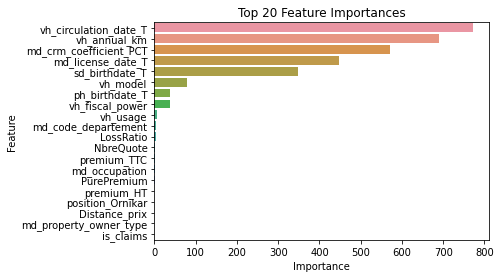

In [ ]:
importances = lgbm.feature_importances_

# Create a pandas DataFrame of feature importances
feat_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance and plot the top features
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


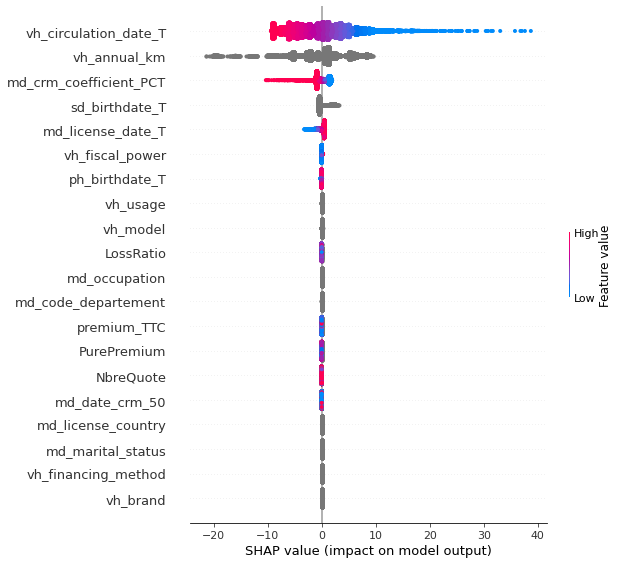

In [ ]:
import shap
shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
IndicesPlusProchesVoisinsReshape = IndicesPlusProchesVoisins.reshape((1,-1))
print(np.shape(IndicesPlusProchesVoisinsReshape))

essai = DonneesLeFuretWakamQuoteRetraite.iloc[IndicesPlusProchesVoisinsReshape[0,:]]
 

# Définir les dimensions de la matrice
rows = np.shape(IndicesPlusProchesVoisins)[0]
cols = np.shape(IndicesPlusProchesVoisins)[1]
print(rows,cols)
# Créer la matrice avec des produits des indices des axes
mat = np.fromfunction(lambda i, j: i, (rows, cols)).reshape((1,-1))

 
essai['ligne'] = mat[0,:]


GroupEssai = essai.groupby(by=['ligne'],dropna=False,as_index=False).agg(
                                                            NbreQuote=pd.NamedAgg(column="NbreQuote", aggfunc="mean"),
                                                            position_Ornikar=pd.NamedAgg(column="position_Ornikar", aggfunc="mean"),
                                                            NbreQuoteOrnikar=pd.NamedAgg(column="premium_TTC", aggfunc=np.count_nonzero),
                                                            premium_HT=pd.NamedAgg(column="premium_HT", aggfunc="mean"),
                                                            PurePremium=pd.NamedAgg(column="PurePremium", aggfunc="mean"),
                                                            Distance_prix=pd.NamedAgg(column="Distance_prix", aggfunc="mean"),
 )
GroupEssai['Distance_prix_PCT'] = GroupEssai['Distance_prix'] /GroupEssai['premium_HT'] # attention, division par prime HT et non TTC
BaseQuotationavecFuret = pd.concat((BaseQuotation,GroupEssai),axis=1)
display(BaseQuotationavecFuret)

#RowLabel['NbrePosition1'] = Output[(Output.position_Ornikar == 1)].position_Ornikar.count()

(1, 531860)
26593 20


C:\Users\guill\AppData\Local\Temp\ipykernel_18780\1360663732.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essai['ligne'] = mat[0,:]


submission_created_at   policy_period_public_id  policy_id  \
0      2023-04-21 11:20:48.675 UTC  pc:SzzJiOQsseH_NcdRH7oMQ      11221   
1      2023-04-12 21:06:17.264 UTC  pc:SiesC-ur7T4_rwMJmAvg6       5735   
2      2023-04-20 13:54:28.393 UTC  pc:SRtC992qCgMZZKlVV8TYo      10557   
3      2023-05-15 10:48:00.616 UTC  pc:STzVkMenc8sVFP8S6yPW0      33138   
4      2023-05-02 13:40:25.568 UTC  pc:SMup1DYYtZljrN8IVjqY5      21666   
...                            ...                       ...        ...   
26588  2023-05-08 17:26:27.488 UTC  pc:SPCOZv1JBarBTgxPaCHLs      26964   
26589   2023-05-12 11:21:06.36 UTC  pc:SO6ImJSl_JJaO_SAmOZRF      30562   
26590  2023-05-12 11:23:02.544 UTC  pc:Shtv1etOOAVchrrzlaRdY      30490   
26591  2023-05-14 19:34:54.269 UTC  pc:SBMRdEpDH2ZbFXpzlgm6J      32578   
26592   2023-05-03 00:21:07.54 UTC  pc:SSpNM7KCJL9z1jC-Ecjnq      22147   

               policy_public_id  job_id                        wakam_quote_id  \
0      pc:Sw6xxrR0dFRRRIlkQz_a2   11322                                   NaN   
1      pc:SbEFW0mmIZR5VKl9UmTVs    5746  d4d0a9ea-e69c-488a-a220-df558685d280   
2      pc:SE1nUqiwSyxNcuOegdxRV   10670                                   NaN   
3      pc:SfBOGb1GBULPn8Bfx6gLL   33843                                   NaN   
4      pc:S7t4VTog_EDUe0ab6PLW5   21967                                   NaN   
...                         ...     ...                                   ...   
26588  pc:SwgBDcg-Ah3BnrMVFHowK   27395  7afec7f3-e1f7-45f2-a4f6-19c228c2af8a   
26589  pc:S8lrFXjfJScil3Ga-6x9m   31535  c2f17afc-b1ed-4e84-8582-9c67ddc39a02   
26590  pc:SDCV36lG88KWzlTVbM7aq   31629  69d4ccde-55f7-46dc-8129-8de48590b747   
26591  pc:S5jBsg7CZgyZ1F6uH91hX   33280  8b6117a4-770f-434c-bcf0-d31a863583d0   
26592  pc:SaQ_BBAhPSKl-Q0_FJX1e   22451  b4d455e6-f271-45f0-b948-cd2b91fc70b4   

      wakam_pricing_version wakam_price_test  wakam_price_test_perc_applied  \
0                       NaN            False                            NaN   
1                        V1            False                           1.04   
2                       NaN            False                            NaN   
3                       NaN            False                            NaN   
4                       NaN            False                            NaN   
...                     ...              ...                            ...   
26588                    V2            False                           1.00   
26589                    V2            False                           1.00   
26590                    V2            False                           1.00   
26591                    V2            False                           1.04   
26592                    V2            False                           1.00   

         job_type  ...  vh_circulation_date_T BaseReference    ligne  \
0      Submission  ...                   1990          True      0.0   
1      Submission  ...                   2015          True      1.0   
2      Submission  ...                   2017          True      2.0   
3      Submission  ...                   2023          True      3.0   
4      Submission  ...                   2023          True      4.0   
...           ...  ...                    ...           ...      ...   
26588  Submission  ...                   2020          True  26588.0   
26589  Submission  ...                   2020          True  26589.0   
26590  Submission  ...                   2020          True  26590.0   
26591  Submission  ...                   2005          True  26591.0   
26592  Submission  ...                   2023          True  26592.0   

      NbreQuote position_Ornikar  NbreQuoteOrnikar   premium_HT  PurePremium  \
0          8.95            17.65                20   431.689000   400.431162   
1          8.45            10.85                20   771.308000   685.905663   
2          9.90             6.65                20   768.544211  1038.927814   
3    

period_status  policy_status
NaN            Draft            15681
Quoted         Draft            10187
Bound          In Force           724
               Draft                1
dtype: int64

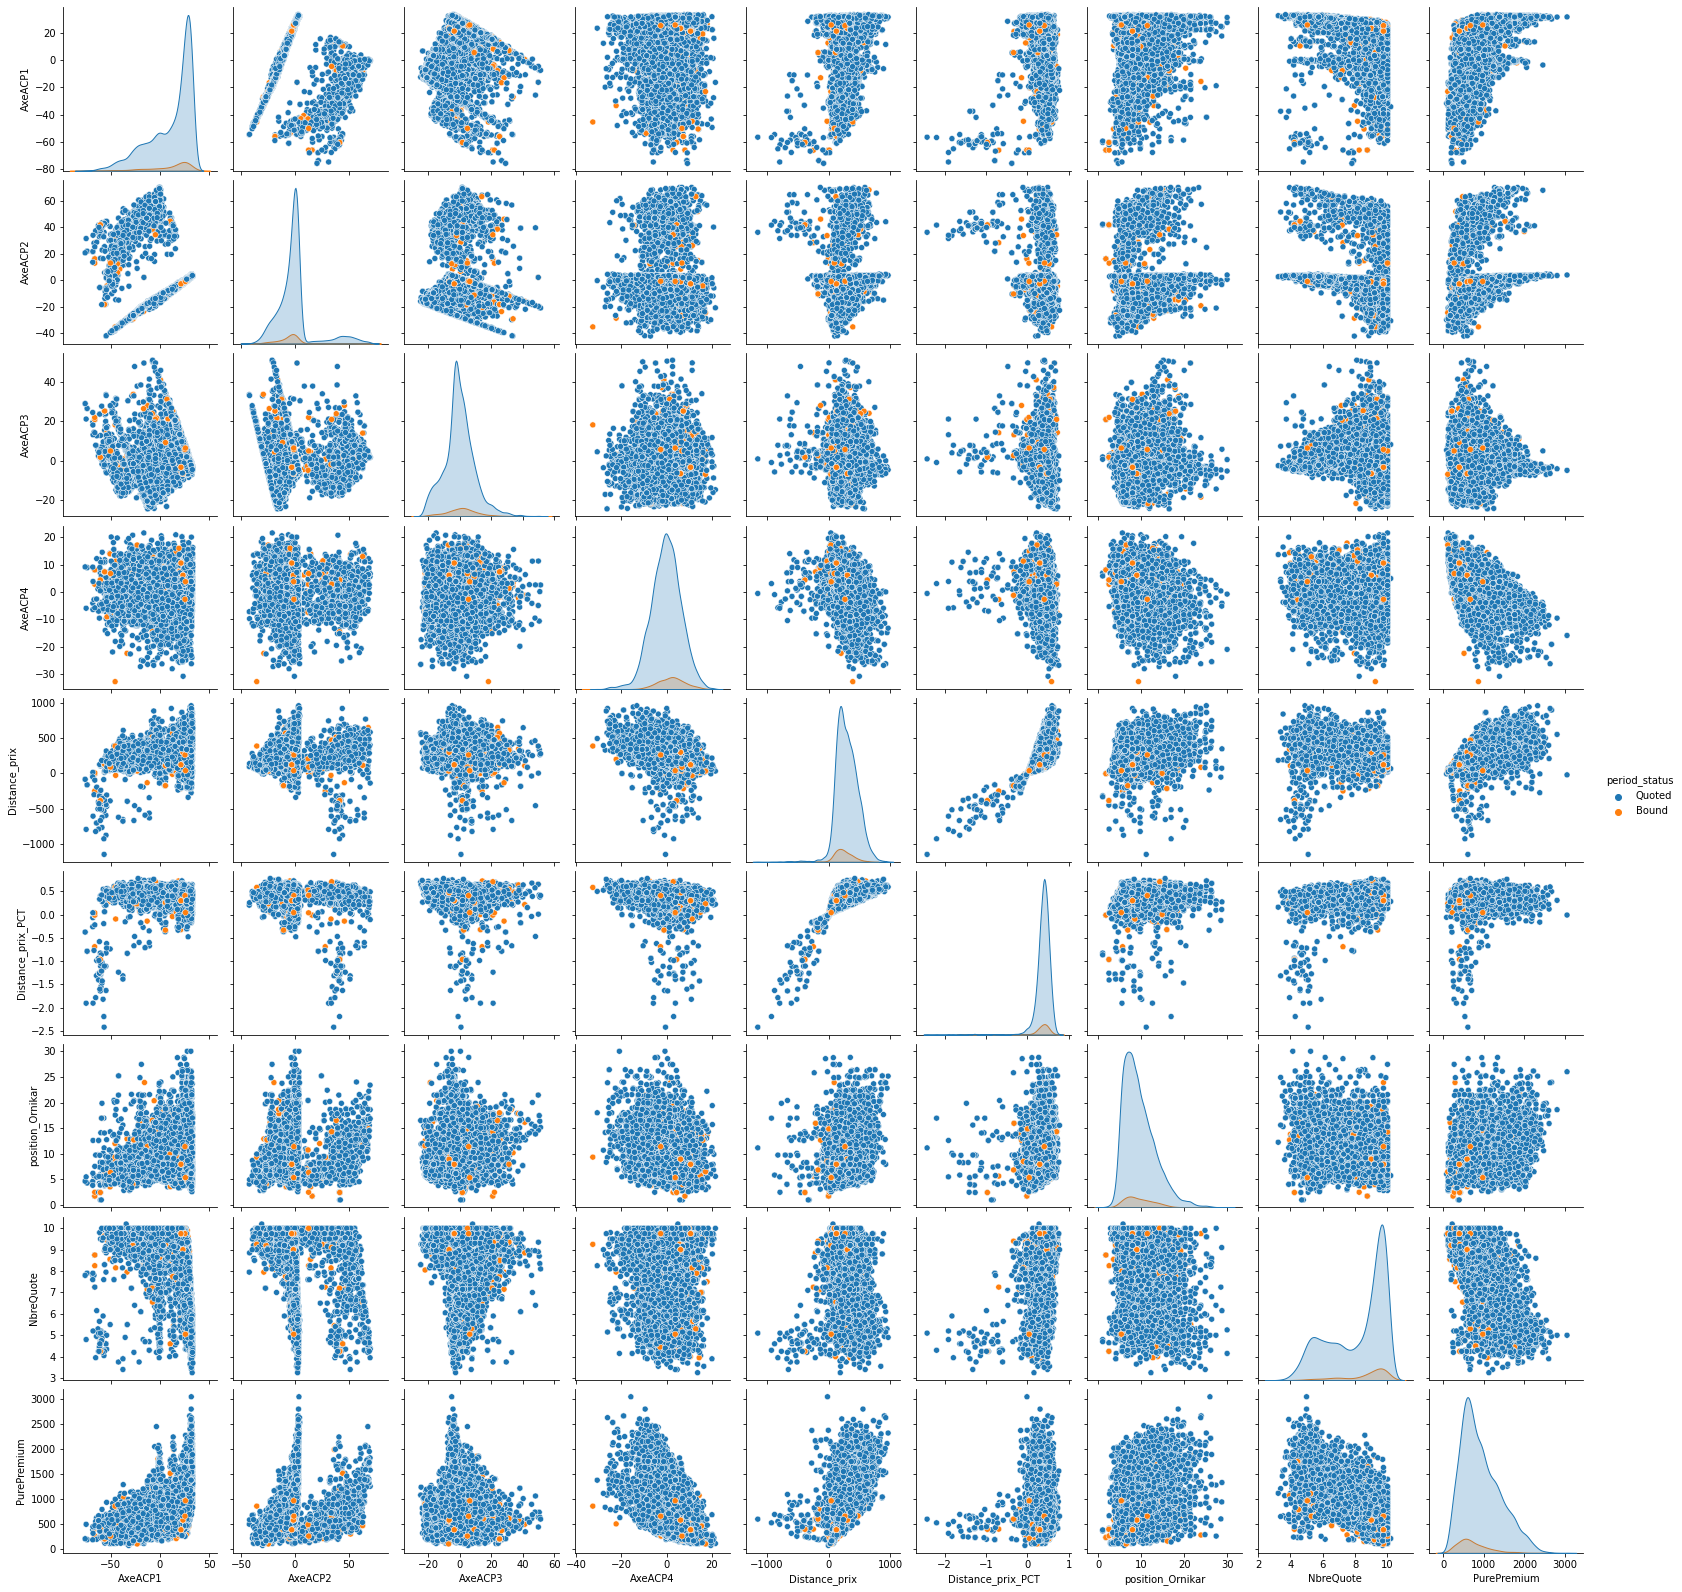

In [ ]:
# Appariement avec les axes de l'ACP
dfBaseQuotationACP = pd.DataFrame(BaseQuotationACP)
dfBaseQuotationACP.columns=["AxeACP"+str(i+1) for i in range(dfBaseQuotationACP.shape[1])]
BaseQuotationavecFuretACP = pd.concat((BaseQuotationavecFuret, dfBaseQuotationACP), axis=1) 
display(BaseQuotationavecFuretACP[['period_status','policy_status']].value_counts(dropna=False))
#display(BaseQuotationavecFuretACP[['AxeACP1','AxeACP2','AxeACP3']])
#BaseQuotationavecFuretACP['period_status']=BaseQuotationavecFuretACP['period_status']
sns.pairplot(data=BaseQuotationavecFuretACP[['period_status','AxeACP1','AxeACP2','AxeACP3','AxeACP4','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']],hue='period_status' )



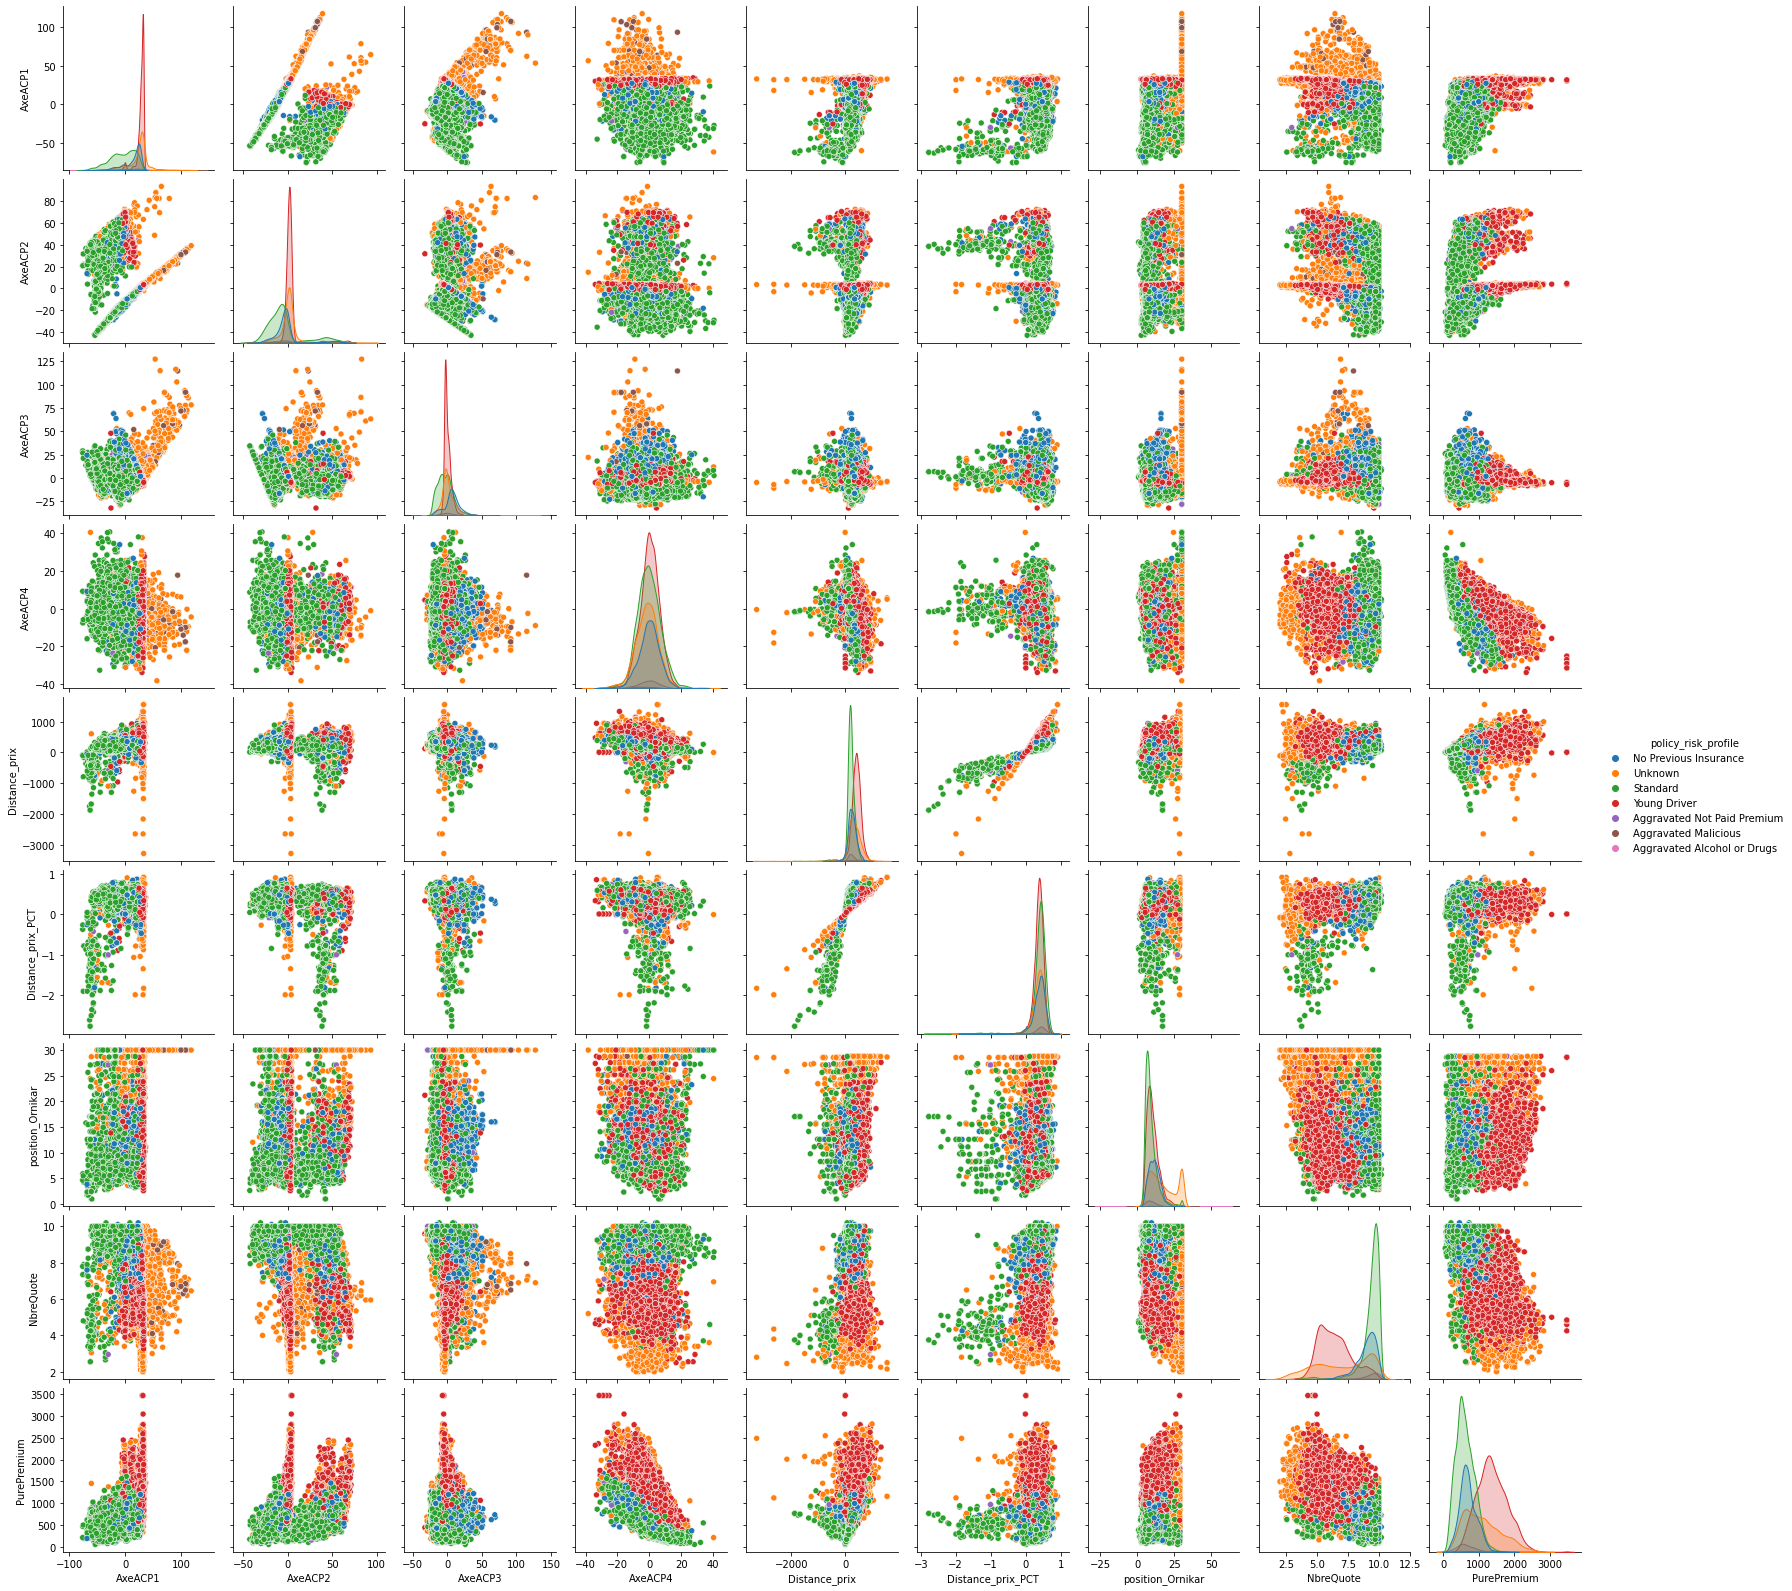

In [ ]:
sns.pairplot(data=BaseQuotationavecFuretACP[['policy_risk_profile','AxeACP1','AxeACP2','AxeACP3','AxeACP4','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']],hue='policy_risk_profile' )

In [ ]:
#BaseQuotationavecFuretACP['job_close_date']

In [ ]:
 
BaseQuotationavecFuretACP['policy_status_ordinal'] = (BaseQuotationavecFuretACP["policy_status"] == "In Force")
 

### Export en csv
BaseQuotationavecFuretACP.to_csv(f'{BASE_PATH_RES}/DonneesLeFuretWakamQuote.csv',sep=',')

### Export en csv
BaseQuotationavecFuretACP[['policy_status','AxeACP1','AxeACP2','AxeACP3','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']].to_csv(f'{BASE_PATH_RES}/PetiteBaseDonnesLeFuretWakamQuote.csv',sep=',')

### Test sur base dédupliquée
Il faudra que je travaille sur la base dédupliquée pour travailler sur ce genre de cas

In [ ]:

BaseQuotationavecFuretACP[(BaseQuotationavecFuretACP['job_number']==5109175117)]


Empty DataFrame
Columns: [submission_created_at, policy_period_public_id, policy_id, policy_public_id, job_id, wakam_quote_id, wakam_pricing_version, wakam_price_test, wakam_price_test_perc_applied, job_type, job_number, job_public_id, job_close_date, bind_date, issue_date, cancellation_date, cancellation_nature, source, sf_submission_id, sf_opportunity_id, original_effective_date, period_start, period_end, period_id, creation_date, update_date, last_policy_period_id, insurer_name, product_code, policy_term_id, risk_type, written_date, loss_history_type, account_id, submission_creation_user_id, submission_creation_user_name, online_offline, update_user_id, is_from_aggregator, generation_source, utm_source, utm_medium, utm_campaign, utm_term, utm_content, recommended_package, package_subtype, policy_risk_profile, policy_risk_profile_edu, has_formulas, has_selected_formula, account_number, account_public_id, ph_first_name, ph_last_name, ph_gender, ph_birthdate, ph_email, ph_phone, md_property_owner_type, md_accommodation_type, phc_policy_contact_role_public_id, md_driver_id, md_first_name, md_last_name, md_gender, md_birthdate, md_phone, md_email, md_occupation, md_marital_status, md_address, md_city, md_zipcode, md_country, md_policy_contact_role_public_id, md_crm_coefficient, md_date_crm_50, md_is_learner_driver, md_license_number, md_license_date, md_license_country, md_ornikarmotor, md_risk_profile, md_learner_id, md_edu_score, md_edu_score_category, md_edu_status, md_edu_impact_premium, md_edu_impact_pure_premium, md_edu_score_version, sd_driver_id, sd_first_name, sd_last_name, sd_gender, sd_birthdate, sd_crm_coefficient, sd_date_crm_50, sd_is_learner_driver, sd_license_number, ...]
Index: []

[0 rows x 300 columns]

In [ ]:
display(BaseQuotationavecFuretACP['policy_status'].value_counts())

Draft       25869
In Force      724
Name: policy_status, dtype: int64

### Analyse des résultats des Axes par régression (pas super propre mais bon...)

In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split
lgbm = LGBMClassifier()
lgbm = LGBMRegressor()
import re
BaseFuretACP = BaseFuretACP.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
BaseFuretACP["AxeACP4Q75"] = (BaseFuretACP["AxeACP4"]>BaseFuretACP["AxeACP4"].quantile(.6))
X_train, X_test, y_train, y_test = train_test_split(BaseFuretACP.drop(columns=["AxeACP4","Unnamed0","id","AxeACP4Q75"]), BaseFuretACP["AxeACP4Q75"], test_size=0.2, random_state=42)
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_train[c] = X_train[c].astype('category')
lgbm.fit(X_train, y_train)

# evaluate the accuracy of the classifier
for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test[c] = X_test[c].astype('category')
accuracy = lgbm.score(X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9368


In [ ]:
X_train.columns

Index(['custom_qr_id', 'NbreQuote', 'date', 'assureur', 'mediane_x', 'moyenne',
       'position_vue', 'prix', 'position_mer', 'devis',
       ...
       'AxeACP11', 'AxeACP12', 'AxeACP13', 'AxeACP14', 'AxeACP15', 'AxeACP16',
       'AxeACP17', 'AxeACP18', 'AxeACP19', 'AxeACP20'],
      dtype='object', length=232)

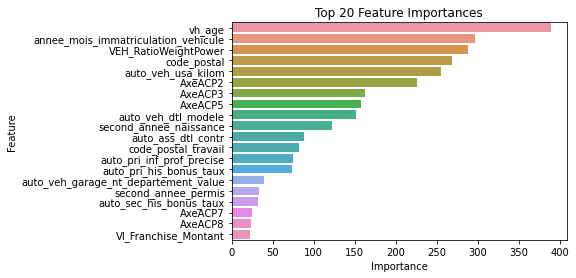

In [ ]:
importances = lgbm.feature_importances_

# Create a pandas DataFrame of feature importances
feat_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance and plot the top features
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


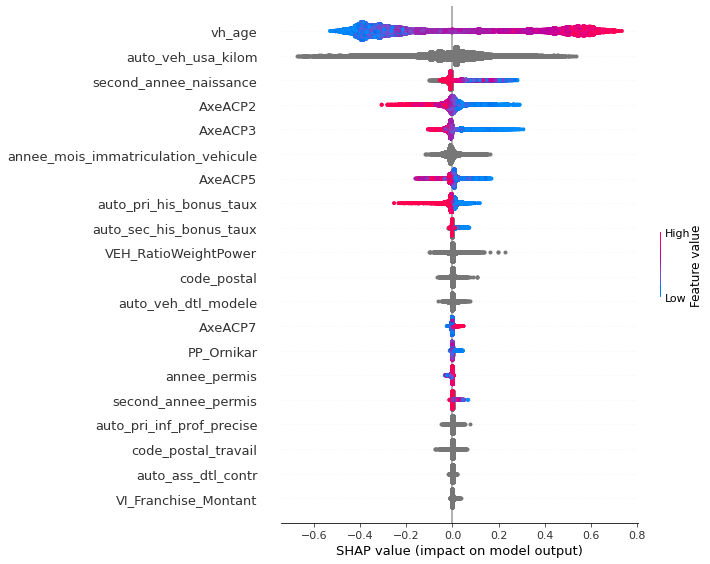

In [ ]:
import shap
shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Appariement avec les axes de l'ACP
dfBaseQuotationACP = pd.DataFrame(BaseQuotationACP)
dfBaseQuotationACP.columns=["AxeACP"+str(i+1) for i in range(dfBaseQuotationACP.shape[1])]
BaseQuotationavecFuretACP = pd.concat((BaseQuotationavecFuret, dfBaseQuotationACP), axis=1) 
display(BaseQuotationavecFuretACP[['period_status','policy_status']].value_counts(dropna=False))
#display(BaseQuotationavecFuretACP[['AxeACP1','AxeACP2','AxeACP3']])
#BaseQuotationavecFuretACP['period_status']=BaseQuotationavecFuretACP['period_status']
sns.pairplot(data=BaseQuotationavecFuretACP[['period_status','AxeACP1','AxeACP2','AxeACP3','AxeACP4','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']],hue='period_status' )



period_status  policy_status
NaN            Rejected         14676
Quoted         Priced            6993
NaN            Priced            4834
Bound          In Force           332
dtype: int64

KeyError: "['Distance_prix', 'Distance_prix_PCT', 'position_Ornikar', 'PurePremium'] not in index"

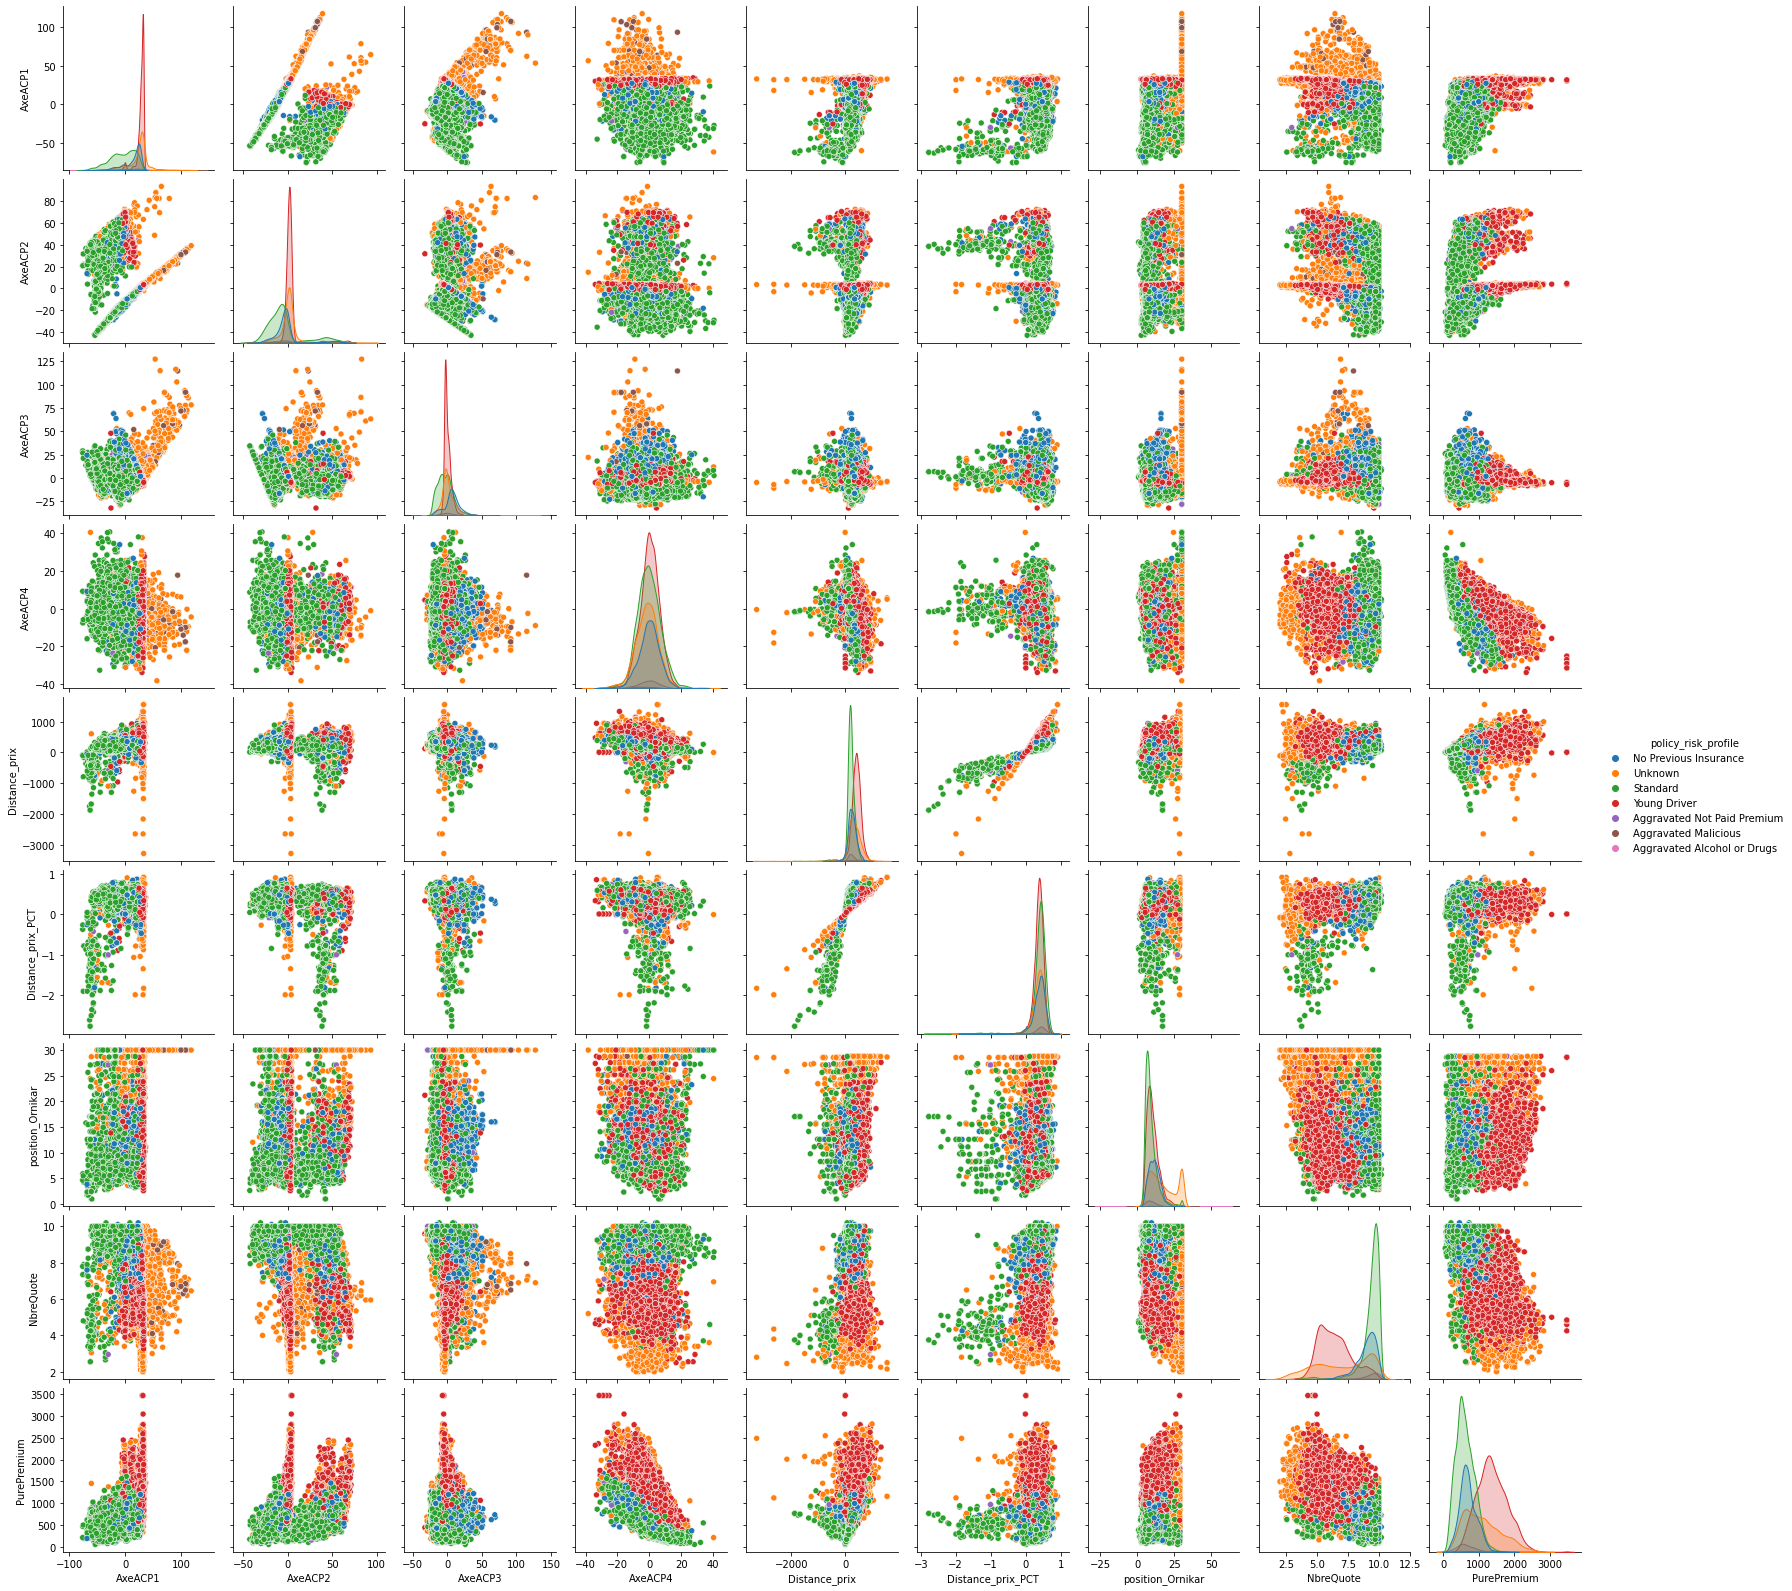

In [ ]:
sns.pairplot(data=BaseQuotationavecFuretACP[['policy_risk_profile','AxeACP1','AxeACP2','AxeACP3','AxeACP4','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']],hue='policy_risk_profile' )

In [ ]:
#BaseQuotationavecFuretACP['job_close_date']

In [ ]:
 
BaseQuotationavecFuretACP['policy_status_ordinal'] = (BaseQuotationavecFuretACP["policy_status"] == "In Force")
 

### Export en csv
BaseQuotationavecFuretACP.to_csv(f'{BASE_PATH_RES}/DonneesLeFuretWakamQuote.csv',sep=',')

### Export en csv
BaseQuotationavecFuretACP[['policy_status','AxeACP1','AxeACP2','AxeACP3','Distance_prix','Distance_prix_PCT','position_Ornikar','NbreQuote','PurePremium']].to_csv(f'{BASE_PATH_RES}/PetiteBaseDonnesLeFuretWakamQuote.csv',sep=',')

### Test sur base dédupliquée
Il faudra que je travaille sur la base dédupliquée pour travailler sur ce genre de cas

In [ ]:

BaseQuotationavecFuretACP[(BaseQuotationavecFuretACP['job_number']==5109175117)]


Empty DataFrame
Columns: [submission_created_at, policy_period_public_id, policy_id, policy_public_id, job_id, wakam_quote_id, wakam_pricing_version, wakam_price_test, wakam_price_test_perc_applied, job_type, job_number, job_public_id, job_close_date, bind_date, issue_date, cancellation_date, cancellation_nature, source, sf_submission_id, sf_opportunity_id, original_effective_date, period_start, period_end, period_id, creation_date, update_date, last_policy_period_id, insurer_name, product_code, policy_term_id, risk_type, written_date, loss_history_type, account_id, submission_creation_user_id, submission_creation_user_name, online_offline, update_user_id, is_from_aggregator, generation_source, utm_source, utm_medium, utm_campaign, utm_term, utm_content, recommended_package, package_subtype, policy_risk_profile, policy_risk_profile_edu, has_formulas, has_selected_formula, account_number, account_public_id, ph_first_name, ph_last_name, ph_gender, ph_birthdate, ph_email, ph_phone, md_property_owner_type, md_accommodation_type, phc_policy_contact_role_public_id, md_driver_id, md_first_name, md_last_name, md_gender, md_birthdate, md_phone, md_email, md_occupation, md_marital_status, md_address, md_city, md_zipcode, md_country, md_policy_contact_role_public_id, md_crm_coefficient, md_date_crm_50, md_is_learner_driver, md_license_number, md_license_date, md_license_country, md_ornikarmotor, md_risk_profile, md_learner_id, md_edu_score, md_edu_score_category, md_edu_status, md_edu_impact_premium, md_edu_impact_pure_premium, md_edu_score_version, sd_driver_id, sd_first_name, sd_last_name, sd_gender, sd_birthdate, sd_crm_coefficient, sd_date_crm_50, sd_is_learner_driver, sd_license_number, ...]
Index: []

[0 rows x 300 columns]

In [ ]:
display(BaseQuotationavecFuretACP['policy_status'].value_counts())

Draft       25869
In Force      724
Name: policy_status, dtype: int64

In [ ]:
    df['submission_created_at'] = pd.to_datetime(df.loc[:,'submission_created_at']).dt.date
    df['bind_date'] = pd.to_datetime(df['bind_date']).dt.date
    df['original_effective_date'] = pd.to_datetime(df['original_effective_date']).dt.date
    df['period_start'] = pd.to_datetime(df['period_start']).dt.date
    df['period_end'] = pd.to_datetime(df['period_end']).dt.date
    df['policy_period_start'] = pd.to_datetime(df['policy_period_start']).dt.date
    df['policy_period_end'] = pd.to_datetime(df['policy_period_end']).dt.date
    df['ph_birthdate'] = pd.to_datetime(df['ph_birthdate']).dt.date
    df['md_birthdate'] = pd.to_datetime(df['md_birthdate']).dt.date
    df['sd_birthdate'] = pd.to_datetime(df['sd_birthdate']).dt.date
    df['md_license_date'] = pd.to_datetime(df['md_license_date']).dt.date
    df['md_date_crm_50'] = pd.to_datetime(df['md_date_crm_50']).dt.date
    df['vh_purchase_date'] = pd.to_datetime(df['vh_purchase_date'],errors = 'coerce').dt.date
    df['vh_circulation_date'] = pd.to_datetime(df['vh_circulation_date'],errors = 'coerce').dt.date
    df['vh_insurance_end_date'] = pd.to_datetime(df['vh_insurance_end_date']).dt.date
